In [23]:
# created by G Oldford rev3
# purpose: plots reporting model perf using LH and SST 
#
# data in: csv's of stats from python analysis app run on server
#          manually input mean and std found in figs produced by Pyap
# data out: 

# notes:
#  - was going to archive this and use pycharm IDE but this works so... 
#  - tried cdat (won't install easily on windows)
#  - tried custom code snippet from ycopin (see below)
#  - tried xcdat (not sure there is a taylor diag)
#  - tried SkillMetrics (won't install via pip or conda, but cloned repo locally)
#  - Aug 17 tried SkillMetrics again and this time it worked. Seems to have been upgraded to avoid a problem by returning 
#      a plot as a subplot... might be better than my current implementation

# last modified Sep 20 2023
# to do: 
#  - adjust target code so that markers are only plotted if they are included in marker list

In [1]:
!python --version

Python 3.9.13


In [36]:
import scipy.io
import os
import pickle
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
import sys
from matplotlib import rcParams
from matplotlib.markers import MarkerStyle
import matplotlib
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import matplotlib.colors as clr
from matplotlib.ticker import ScalarFormatter
import math
from math import log10, floor
from array import array
import numbers
from matplotlib.lines import Line2D
import warnings
from matplotlib.markers import MarkerStyle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#Taylor axes code

from matplotlib.projections import PolarAxes
import mpl_toolkits.axisartist.floating_axes as FA
import mpl_toolkits.axisartist.grid_finder as GF

def get_taylor_diagram_axes(fig, rect, refstd, srange, contour_levs, clr_std_cntr, gs_on=False, gs_col=[0], gs_row=[0], extend=False):
    
    grid_clr = '#969696'
    cntr_clr = '#858585'
    cntr_lw = 0.8
    clbl_sz = 10
    clbl_clr = '#858585'
    axs_lbl_fs = 10
    str_sz = 9
    star_offset = 0.02
    
    # Correlation labels
    rlocs = np.array([0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.99, 1])
    
    tr = PolarAxes.PolarTransform()
    
    if extend:
        # Diagram extended to negative correlations
        tmax = np.pi
        rlocs = np.concatenate((-rlocs[:0:-1], rlocs))
    else:
        # Diagram limited to positive correlations
        tmax = np.pi/2
    
    tlocs = np.arccos(rlocs)        # Conversion to polar angles
    gl1 = GF.FixedLocator(tlocs)    # Positions
    tf1 = GF.DictFormatter(dict(zip(tlocs, map(str, rlocs))))

    # Standard deviation axis extent (in units of reference stddev)
    smin = srange[0] * refstd
    smax = srange[1] * refstd
    
    ghelper = FA.GridHelperCurveLinear(
        tr,
        extremes=(0, tmax, smin, smax),
        grid_locator1=gl1, 
        tick_formatter1=tf1
    )

    ax = FA.FloatingSubplot(fig, rect, grid_helper=ghelper)
    
    if gs_on:
        fig.add_subplot(gs[gs_row,gs_col])
    else:
        fig.add_subplot(ax)
    

    # Adjust axes
    ax.axis["top"].set_axis_direction("bottom")   # "Angle axis"
    ax.axis["top"].toggle(ticklabels=True, label=True)
    ax.axis["top"].major_ticklabels.set_axis_direction("top")
    
    ax.axis["top"].label.set_axis_direction("top")
    ax.axis["top"].label.set_text("Correlation")

    ax.axis["left"].set_axis_direction("bottom")  # "X axis"
    ax.axis["left"].label.set_text("Standard deviation")

    ax.axis["right"].set_axis_direction("top")    # "Y-axis"
    ax.axis["right"].toggle(ticklabels=True)
    ax.axis["right"].major_ticklabels.set_axis_direction(
        "bottom" if extend else "left")

    if smin:
        ax.axis["bottom"].toggle(ticklabels=False, label=False)
    else:
        ax.axis["bottom"].set_visible(False)          # Unused

    # Graphical axes
    _ax = ax
    ax = ax.get_aux_axes(tr)   # Polar coordinates

    
    # Add reference point and stddev contour
    l, = ax.plot([0+star_offset], refstd, 'k*', ls='', ms=str_sz, label="", zorder=10)
    t = np.linspace(0, tmax)
    r = np.zeros_like(t) + refstd
    ax.plot(t, r, '--', label='_', color=clr_std_cntr)
    
    rs, ts = np.meshgrid(np.linspace(smin, smax), np.linspace(0, tmax))
    
    # Compute centered RMS difference
    rms = np.sqrt(refstd**2 + rs**2 - 2*refstd*rs*np.cos(ts))

    
    _ax.grid(ls='-',color=grid_clr,lw=0.8) 
    
    _ax.axis[:].major_ticks.set_tick_out(True)
    _ax.xaxis.set_tick_params(labelsize=2)
    _ax.axis["top"].label.set_text("Correlation")
    _ax.axis["left"].label.set_text("Normalized standard deviation")
    _ax.axis["left"].label.set_fontsize(axs_lbl_fs)
    _ax.axis["top"].label.set_fontsize(axs_lbl_fs)
    _ax.axis["top"].major_ticklabels.set_fontsize(axs_lbl_fs-1)
    _ax.axis["left"].major_ticklabels.set_fontsize(axs_lbl_fs-1)
    _ax.axis["right"].major_ticklabels.set_fontsize(axs_lbl_fs-1)
    
    
    
    
    contours = ax.contour(ts, rs, rms, colors=cntr_clr, levels = contour_levs, linewidths = cntr_lw, linestyles='--')
    plt.clabel(contours, inline=1, fontsize=clbl_sz, fmt='%.1f', colors=clbl_clr)

#     # Collect sample points for latter use (e.g. legend)
#     self.samplePoints = [l]   

    return ax


def plot_taylor_data(ax,modelruns_info,var,augment_rmse,buoy_list,o_markers):
    # get data and plot
    for run in modelruns_info.keys():

        if var == "temperature":
            print("Taylor SST", run)
        elif var == "salinity":
            print("Taylor SSS", run)
        else:
            print("No variable chosen")
            break
            
        path1 = modelruns_info[run]['path']
        shortcode = modelruns_info[run]['shortcode']
        colour_m = modelruns_info[run]['colour']

        # plot markers
        facecolor1 = colour_m
        facecolor2 = colour_m
        edgecolor1 = colour_m
        edgecolor2 = colour_m
        medgew1 = 0.2
        medgew2 = 0.2

        # get lighthouse data
        LH_pic_data = 'LH_class4_' + shortcode + '_hindcast.pickle'
        LH_scores = pickle.load(open(os.path.join(path1,LH_pic_data), 'rb'))   

        # should modify - no need to be returning target stats here
        lh_stats_taylor_np, lh_stats_target_np = get_lh_stats(LH_scores, run, augment_rmse, var)

        if var == "temperature":
            # SST buoy data
            SSTbuoy_pic_data = "SST_class4_" + run + ".pickle"
            SSTbuoy_scores = pickle.load(open(os.path.join(path1,SSTbuoy_pic_data), 'rb'))

            # looks like:
            # SSTbuoy_scores['SalishSea1500-RUN203']['ptaw1']['filt_interp_data']['scores'].keys()
            # dict_keys(['skill1981', 'mean_obs', 'mean_mod', 'bias', 'crmse', 'gamma2', 'rmse', 'mae', 'mad', 'pearson', 'stdev_obs', 'stdev_mod'])
            buoy_stats_taylor_np, buoy_stats_target_np = get_SSTbuoy_stats(SSTbuoy_scores, run, augment_rmse, buoy_list)
            
#             #     # check stats in ss five hundred
#             if run == 'SalishSea500-201905':
#                 print("lh stats taylor")
#                 print(lh_stats_taylor_np)
#                 print("buoy stats taylor")
#                 print(buoy_stats_taylor_np)
#                 print("buoy scores")
#                 print(SSTbuoy_scores[run].keys())
#                 print(buoy_list)


            SST_taylor_np_buoys_and_LH = np.concatenate((lh_stats_taylor_np,buoy_stats_taylor_np))

#             ccoef = SST_taylor_np_buoys_and_LH[:,6].astype('f')
#             sdev = SST_taylor_np_buoys_and_LH[:,3].astype('f')
            stats_array = SST_taylor_np_buoys_and_LH

        elif var == "salinity":
            
#             ccoef = lh_stats_taylor_np[:,6].astype('f')
#             sdev = lh_stats_taylor_np[:,3].astype('f')
            stats_array = lh_stats_taylor_np
        
        
        for i in range(len(stats_array)):
            stn_data = stats_array[i]
            stn = stn_data[0]
            if stn in o_markers:
                stddev = stn_data[3].astype('f')
                corrcoef = stn_data[6].astype('f')
                
                ax.plot(np.arccos(corrcoef), 
                    stddev, 
                    marker=o_markers[stn]['symbol'],
                    ms=o_markers[stn]['size'],
                    ls='',
                    #mfc=colors[i],
                    #mfc=o_markers[stn]['facecolor'],
                    mfc=colour_m,
                    #mec=colors[i],
                    mec=edgecolor1,
                    mew=medgew1,
                    #label="%d" % (i+1)),
                    label=o_markers[stn]['label']
                   ) 
            else: 
                continue
            
            
        
#         pairs_stats = []
#         print(sdev)
#         for i in range(len(sdev)+1):
#             if i == 0:
#                 stn = "reference"
#                 sig = 1
#                 cc = 1
#             else:
                
#                 stn = o_markerlabel[i-1]
#                 sig = sdev[i-1]
#                 cc = ccoef[i-1]
#             pairs_stats.append([stn,[sig,cc]])

#         # Add the model markers to Taylor diagram
#         i = 0
#         for i, (stn, stats) in enumerate(pairs_stats):
#             # avoid douvble-plotting ref
            
#             stddev = stats[0]
#             corrcoef = stats[1]

#             #print(corrcoef)
#             ax.plot(np.arccos(corrcoef), 
#                     stddev, 
#                     marker=o_markers[stn]['symbol'],
#                     ms=o_markers[stn]['size'],
#                     ls='',
#                     #mfc=colors[i],
#                     #mfc=o_markers[stn]['facecolor'],
#                     mfc=colour_m,
#                     #mec=colors[i],
#                     mec=edgecolor1,
#                     mew=medgew1,
#                     #label="%d" % (i+1)),
#                     label=o_markers[stn]['label']
#                    )
            
        
    return ax
 
## TARGET DIAGRAM CODE
### GET AXES #####
# function get_target_diagram_axes(RMSDs,Bs,option) -->
def get_target_diagram_axes(ax, options):
      
    # unused?
    circlecols = options['circlecols'] 
    
    equalaxes = options['equalaxes']
    normalized = options['normalized']
    ticklabcolor= options['ticklabcolor']
    axesedgecolor = options['axesedgecolor']
    overlay = options['overlay']
    fontsizelab = options['fontsizelab']
    fontsizelab_ticks = options['fontsizelab_ticks']
    bias_label = options['bias_label']
    RMSD_label = options['RMSD_label']
    b_lab_rot = options['b_lab_rot']
    rmsd_lab_rot = options['rmsd_lab_rot']
    b_lab_pos_yoffset = options['b_lab_pos_yoffset']
    b_lab_pos_xoffset = options['b_lab_pos_xoffset']
    rmsd_lab_pos_yoffset = options['rmsd_lab_pos_yoffset']
    rmsd_lab_pos_xoffset = options['rmsd_lab_pos_xoffset']
    axismax = options['axismax']
    ticks = options['ticks']
    xticklabelpos = options['xticklabelpos']
    yticklabelpos = options['yticklabelpos']
    yticklabelpos = options['yticklabelpos'] 
    o_circles = options['o_circles']
    #'circlelinespec':'k--',
    circlelinespec = options['circlelinespec']
    circlestyle = options['circlestyle']
    circlelinewidth = options['circlelinewidth']
    circlecolor = options['circlecolor']
    obsuncertainty = options['obsuncertainty']
    lineWidth = options['linewidth']
    
    foundmax = 1 if axismax != 0.0 else 0
    if foundmax == 0:
        # Axis limit not specified
        maxx = np.amax(np.absolute(x))
        maxy = np.amax(np.absolute(y))
    else:
        # Axis limit is specified
        maxx = axismax
        maxy = axismax

    # Determine default number of tick marks
    xtickvals = ticker.AutoLocator().tick_values(-1.0*maxx, maxx)
    ytickvals = ticker.AutoLocator().tick_values(-1.0*maxy, maxy)
    nxticks = np.sum(xtickvals > 0)
    nyticks = np.sum(ytickvals > 0)

    # Set default tick increment and maximum axis values
    if foundmax == 0:
        maxx = xtickvals[-1]
        maxy = ytickvals[-1]
        axismax = max(maxx, maxy)

    # Check if equal axes requested
    if equalaxes == 'on':
        if maxx > maxy:
            maxy = maxx
            nyticks = nxticks
        else:
            maxx = maxy
            nxticks = nyticks

    # Convert to integer if whole number
    if type(maxx) is float and maxx.is_integer(): maxx = int(round(maxx))
    if type(maxx) is float and maxy.is_integer(): maxy = int(round(maxy))
    minx = -maxx; miny = -maxy

    # Determine tick values
    if len(ticks) > 0:
        xtick = ticks; ytick = ticks
    else:
        tincx = maxx/nxticks; tincy = maxy/nyticks
        xtick = np.arange(minx, maxx+tincx, tincx)
        ytick = np.arange(miny, maxy+tincy, tincy)

    # Assign tick label positions
    if len(xticklabelpos) == 0:
        xticklabelpos= xtick
    if len(yticklabelpos) == 0:
        yticklabelpos= ytick

    #define x offset
    thexoffset = find_exp(maxx)

    if use_sci_notation(maxx): 
        ixsoffset = True
        xsoffset_str = "$\tx\mathdefault{10^{"+ str(thexoffset) +"}}\mathdefault{}$"
    else:
        ixsoffset = False
        xsoffset_str = 'None'

    theyoffset = find_exp(maxy)
    if use_sci_notation(maxy): 
        iysoffset = True
        ysoffset_str = "$\tx\mathdefault{10^{"+str(theyoffset)+"}}\mathdefault{}$"
    else:
        iysoffset = False
        ysoffset_str = 'None'

    # Set tick labels using provided tick label positions
    xlabel =[]; ylabel = [];

    # Set x tick labels
    for i in range(len(xtick)):
        index = np.where(xticklabelpos == xtick[i])
        if len(index) > 0:
            thevalue = xtick[i]
            if ixsoffset: 
                thevalue = xtick[i] * (10**(-1*thexoffset))
                label = get_axis_tick_label(thevalue)
                xlabel.append(label)
            else:
                label = get_axis_tick_label(xtick[i])
                xlabel.append(label)
        else:
            xlabel.append('')

    # Set tick labels at 0 to blank
    # print(xtick)
    blank_at_zero(xtick,xlabel)

    # Set y tick labels
    for i in range(len(ytick)):
        index = np.where(yticklabelpos == ytick[i])
        if len(index) > 0:
            thevalue = ytick[i]
            if iysoffset: 
                thevalue = ytick[i] * (10**(-1*theyoffset)) 
                label = get_axis_tick_label(thevalue)
                ylabel.append(label)
            else:
                label = get_axis_tick_label(ytick[i])
                ylabel.append(label)
        else:
            ylabel.append('')

    # Set tick labels at 0 to blank
    blank_at_zero(ytick,ylabel)

    # Store output variables in data structure
    axes = {}
    axes['xtick'] = xtick
    axes['ytick'] = ytick
    axes['xlabel'] = xlabel
    axes['ylabel'] = ylabel
    axes['xoffset'] = xsoffset_str
    axes['yoffset'] = ysoffset_str
    # END function get_target_diagram_axes


    #### Overlay circles ####
    # function overlay_target_diagram_circles(ax: matplotlib.axes.Axes, option: dic) -->
    theta = np.arange(0, 2*np.pi, 0.01)
    unit = np.ones(len(theta))

    # 1 - reference circle if normalized
    if normalized == 'on':
        rho = unit
        X, Y = pol2cart(theta, rho)
        ax.plot(X, Y, 'k', 'LineWidth', circleLineWidth)

    # Set range for target circles
    if normalized == 'on':
        circles = [.5, 1]
    else:
        if o_circles is None:
            circles = [axismax * x for x in [.7, 1]]
        else:
            circles = np.asarray(o_circles)
            index = np.where(circles <= axismax)
            circles = [o_circles[i] for i in index[0]]

    # 2 - secondary circles
    for c in circles:
        rho = c * unit
        X, Y = pol2cart(theta, rho)
        ax.plot(X, Y, linestyle=circlestyle,
                color=circlecolor,
                linewidth=circlelinewidth,
                zorder=1
               )
    del c

    # 3 - Observational Uncertainty threshold
    if obsuncertainty > 0:
        rho = obsuncertainty * unit
        X, Y = pol2cart(theta, rho)
        ax.plot(X, Y, '--b')
    # END function overlay_target_diagram_circles


    # Modify axes for target diagram (no overlay)
    # if option['overlay'] == 'off':
    #     axes_handles = plot_target_axes(ax, axes)
    # function plot_target_axes -->   
    if overlay == 'off':    
        axes_handles = []
        fontFamily = rcParams.get('font.family')

        # Center axes location by moving spines of bounding box
        # Note: Center axes location not available in matplotlib
        ax.spines['left'].set_position('zero')
        ax.spines['bottom'].set_position('zero')
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')

        # Make axes square
        ax.set_aspect('equal')

        # Set new ticks and tick labels
        ax.set_xticks(axes['xtick'], color=axesedgecolor)
        ax.set_xticklabels(axes['xlabel'], fontfamily=fontFamily, color=ticklabcolor, fontsize = fontsizelab_ticks)
        ax.set_yticks(axes['ytick'], color=axesedgecolor)
        ax.set_yticklabels(axes['ylabel'], fontfamily=fontFamily, color=ticklabcolor, fontsize = fontsizelab_ticks)

        # Set axes limits
        axislim = [axes['xtick'][0], axes['xtick'][-1], axes['ytick'][0], axes['ytick'][-1]]
        ax.set_xlim(axislim[0:2])
        ax.set_ylim(axislim[2:])

        # Label x-axis
#         fontSize = matplotlib.rcParams.get('font.size')
        xpos = axes['xtick'][-1] + 2*axes['xtick'][-1]/30
        ypos = axes['xtick'][-1]/30
        if axes['xoffset'] == 'None':
            ax.set_xlabel(RMSD_label, fontsize = fontsizelab, rotation=rmsd_lab_rot, zorder=10)
        else:
            ax.set_xlabel(RMSD_label + '\n(' + axes['xoffset'] + ')', fontsize = fontsizelab, rotation=rmsd_lab_rot, zorder=10)
        xlabelh = ax.xaxis.get_label()
        xlabelh.set_horizontalalignment('left')
        ax.xaxis.set_label_coords(xpos+rmsd_lab_pos_xoffset, ypos+rmsd_lab_pos_yoffset, transform=ax.transData)
        ax.tick_params(axis='both', direction='in', length=0.1) # have ticks above axis
#         ax.tick_params(direction='out', length=6, width=2, colors='r',
#                grid_color='r', grid_alpha=0.5)

        # Label y-axis
        xpos = 0
        ypos = axes['ytick'][-1] + 2*axes['ytick'][-1]/30
        if axes['yoffset'] == 'None':        
            ax.set_ylabel(bias_label + ' ', fontsize = fontsizelab, rotation=b_lab_rot)
        else:
            ax.set_ylabel(bias_label + ' ' + '(' + axes['yoffset'] + ')', fontsize = fontsizelab, rotation=b_lab_rot)

        ylabelh = ax.yaxis.get_label()
        ylabelh.set_horizontalalignment('center')
        ax.yaxis.set_label_coords(xpos+b_lab_pos_xoffset, ypos+b_lab_pos_yoffset, transform=ax.transData)
        ax.tick_params(axis='y', direction='in') # have ticks on right side of axis

        # Set axes line width
        #lineWidth = rcParams.get('lines.linewidth')
        ax.spines['left'].set_linewidth(lineWidth)
        ax.spines['bottom'].set_linewidth(lineWidth)

        ax.spines['left'].set_edgecolor(axesedgecolor)
        ax.spines['bottom'].set_edgecolor(axesedgecolor)
        ax.spines['left'].set_color(axesedgecolor)
        ax.spines['bottom'].set_color(axesedgecolor)

    # END function plot_target_axes --> 
    return ax #get_target_diagram_axes
    
            
def plot_target_data1(ax,modelruns_info,var,augment_rmse, options):


    # loop over model runs, add data
    for run in modelruns_info.keys():
      
        if var == "temperature":
            print("Target SST", run)
        elif var == "salinity":
            print("Target SSS", run)
        else:
            print("No variable chosen")
            break
    
        path1 = modelruns_info[run]['path']
        shortcode = modelruns_info[run]['shortcode']
        colour_m = modelruns_info[run]['colour']
        
        # markers
        facecolor1 = colour_m
        facecolor2 = colour_m
        edgecolor1 = colour_m
        edgecolor2 = colour_m
        medgew1 = 0.2
        medgew2 = 0.2
        

        # get lighthouse data
        LH_pic_data = 'LH_class4_' + shortcode + '_hindcast.pickle'
        LH_scores = pickle.load(open(os.path.join(path1,LH_pic_data), 'rb'))             
        lh_stats_taylor_np, lh_stats_target_np = get_lh_stats(LH_scores, run, augment_rmse, var)
        
        # if temp, then use buoys otherwise just lh data
        if var == "temperature":
             # SST buoy data
            SSTbuoy_pic_data = "SST_class4_" + run + ".pickle"
            #print(os.path.join(path1,SSTbuoy_pic_data)
            SSTbuoy_scores = pickle.load(open(os.path.join(path1,SSTbuoy_pic_data), 'rb'))

            # looks like:
            # SSTbuoy_scores['SalishSea1500-RUN203']['ptaw1']['filt_interp_data']['scores'].keys()
            # dict_keys(['skill1981', 'mean_obs', 'mean_mod', 'bias', 'crmse', 'gamma2', 'rmse', 'mae', 'mad', 'pearson', 'stdev_obs', 'stdev_mod'])
            buoy_stats_taylor_np, buoy_stats_target_np = get_SSTbuoy_stats(SSTbuoy_scores, run, augment_rmse, buoy_list)
            SST_taylor_np_buoys_and_LH = np.concatenate((lh_stats_taylor_np,buoy_stats_taylor_np))
            SST_target_np_buoys_and_LH = np.concatenate((lh_stats_target_np,buoy_stats_target_np))

            Bs = SST_target_np_buoys_and_LH[:,5].astype('f')
            RMSDs =  SST_target_np_buoys_and_LH[:,4].astype('f')

        elif var == "salinity":
            Bs = lh_stats_target_np[:,5].astype('f')
            RMSDs =  lh_stats_target_np[:,4].astype('f')

        ax, handles, labels = plot_target_data2(ax,RMSDs,Bs,options, facecolor1, edgecolor1, medgew1)
      
    return ax

def plot_target_data2(ax,RMSDs,Bs,options, facecolor1, edgecolor1, medgew1):

    # to do: pass stations in, too - along with bs rmsds - cross check labels with o_markers
    
    x = RMSDs
    y = Bs 
    
    # Set font and marker size
    fontSize = matplotlib.rcParams.get('font.size') 

    o_markers = options['o_markers']
    o_markerstyle = options['o_markerstyle'] # added by GO - "font" / "symbol"
    o_markersize = options['o_markersize']
    o_markersymbol = options['o_markersymbol'] #'+','o','x','s','d','^','v','p','h','*'
    o_markercolor = options['o_markercolor'] # single color to use for all markers (Default: None)
    o_markercolors = options['o_markercolors'] # if None, considers 'markercolor' only; dictionary with two colors as keys ('face', 'edge')
#                             or None. If None or 'markerlegend' == 'on' then
#                             considers only the value of 'markercolor'. (Default: None)
    o_markerlabelcolor = options['o_markerlabelcolor']
    markerdisplayed = options['markerdisplayed']
    markerobs = options['markerobs']
    markerlegend = options['markerlegend']
    alpha = options['alpha']
    stylebias = options['stylebias']
    numberpanels = options['numberpanels']
    face = options['face']
    edge = options['edge']
    cmap = options['cmap']
    cmap_vmin = options['cmap_vmin']
    cmap_vmax = options['cmap_vmax']
    cmap_marker = options['cmap_marker']
    cmapzdata = options['cmapzdata']
    colframe = options['colframe']
    colormap = options['colormap']
    labelweight = options['labelweight']
    locationcolorbar = options['locationcolorbar']
    axismax = options['axismax']
    
    target_options_file = options['target_options_file']
    titlecolorbar = options['titlecolorbar']

    # Check enough labels provided if markerlabel provided. Not a problem if labels
    # provided via the markers option.
    o_markerlabel = []
    for mrkr in o_markers:
        o_markerlabel.append(o_markers[mrkr]['label'])
    
    numberLabel = len(o_markerlabel)
    
    if numberLabel > 0:
        if isinstance(o_markerlabel, list) and numberLabel < len(RMSDs):
            raise ValueError('Insufficient number of marker labels provided.\n' +
                             'target: No. labels=' + str(numberLabel) + ' < No. markers=' +
                             str(len(RMSDs)) + '\n' +
                             'taylor: No. labels=' + str(numberLabel+1) + ' < No. markers=' +
                             str(len(RMSDs)+1))
        elif isinstance(o_markerlabel, dict) and numberLabel > 70: # what is this? GLO why 70?
            raise ValueError('Insufficient number of marker labels provided.\n' +
                             'target: No. labels=' + str(numberLabel) + ' > No. markers= 70')

    if markerlegend == 'on':
        # Check that marker labels have been provided
        if o_markerlabel == '' and o_markers == None:
            raise ValueError('No marker labels provided.')

        # Plot markers of different color and symbols with labels displayed in a legend
        limit = axismax
        hp = ()
        rgba = None

        if o_markers is None:

            # Define default markers (function)
    #         marker, markercolor = get_default_markers(X, option)
            #get_default_markers:
    #         alpha = option['alpha']

            # Define list of marker symbols and colros
            kind = ['+','o','x','s','d','^','v','p','h','*']
            colorm = ['r','b','g','c','m','y','k','gray']
            if len(RMSDs) > 80:
                print('You must introduce new markers to plot more than 70 cases.')
                print('The ''marker'' character array need to be extended inside the code.')

            if len(RMSDs) <= len(kind):
                # Define markers with specified color
                marker = []
                markercolor = []
                if o_markercolor is None:
                    for i, color in enumerate(colorm):
                        rgba = clr.to_rgb(color) + (alpha,)
                        marker.append(kind[i] + color)
                        markercolor.append(rgba)
                else:
                    rgba = clr.to_rgb(o_markercolor) + (alpha,)
                    for symbol in kind:
                        marker.append(symbol + o_markercolor)
                        markercolor.append(rgba)
            else:
                # Define markers and colors using predefined list
                marker = []
                markercolor = []
                for color in colorm:
                    for symbol in kind:
                        marker.append(symbol + color)
                        rgba = clr.to_rgb(color) + (alpha,)
                        markercolor.append(rgba)
            # END get_default_markers


            # Plot markers at data points
            labelcolor = []
            markerlabel = []
            handles = []
            labels = []
            for i, xval in enumerate(RMSDs):
                if abs(RMSDs[i]) <= limit and abs(Bs[i]) <= limit:
                    h = ax.plot(RMSDs[i],
                                Bs[i],
                                marker[i], 
                                markersize = o_markersize,
                                markerfacecolor = markercolor[i],
                                markeredgecolor = markercolor[i][0:3] + (1.0,),
                                markeredgewidth = 1)
                    hp += tuple(h)
                    labelcolor.append(o_markerlabelcolor)
                    markerlabel.append(o_markerlabel[i])
                    labels.append(o_markerlabel[i])
                    handles.append(h)

        # if there's an o_markers dictionary
        else:
            # Obtain markers from option['markers']
            #labels, labelcolor, marker, markersize, markerfacecolor, markeredgecolor = \
                #get_single_markers(option['markers'])

            #get_single_markers -->
            if o_markers is None:
                raise ValueError("Empty dictionary provided for option['markers']")

            labelcolor = []
            marker = []
            markerfacecolor = []
            markeredgecolor = []
            markerlabel = []
            markersize = []
            markeredgewidth = []

    #         if o_markerstyle == "font":
    #             marker_style.update(markeredgecolor="none", markersize=15)

            # Iterate through keys in dictionary
            for key in o_markers:
#                 color = o_markers[key]['facecolor']
                color = facecolor1
                symbol = o_markers[key]['symbol']

                if o_markerstyle != "font":
                    SymbolColor = symbol + color
                    marker.append(SymbolColor)
                else:
                    marker.append(symbol)
                    fontFamily = rcParams.get('font.family')

                markersize.append(o_markers[key]['size'])
#                 markerfacecolor.append(color)
                markerfacecolor.append(facecolor1)
#                 markeredgecolor.append(o_markers[key]['edgecolor'])
                markeredgecolor.append(edgecolor1)
#                 markeredgewidth.append(o_markers[key]['edgewidth'])
                markeredgewidth.append(medgew1)
                markerlabel.append(key) # store label
#                 labelcolor.append(o_markers[key]['labelcolor'])
                labelcolor.append(facecolor1)
                
            # end get_single_markers
            
            # Plot markers at data points
            handles = []
            labels = []
            for i, xval in enumerate(RMSDs):
                if abs(RMSDs[i]) <= limit and abs(Bs[i]) <= limit:
#                     print(markerlabel[i])
#                     print(Bs[i])
                    h = ax.plot(RMSDs[i],
                                Bs[i],
                                marker=marker[i],
                                markersize = markersize[i],
                                markerfacecolor = markerfacecolor[i],
                                markeredgecolor = markeredgecolor[i],
                                markeredgewidth = markeredgewidth[i],
                                alpha=alpha)
                    hp += tuple(h)
                    handles.append(h)
                    labels.append(markerlabel[i])
                    #markerlabel.append(labels[i])

    else:
        # Plot markers as dots of a single color with accompanying labels
        limit = axismax

        # Define edge and face colors of the markers
        #                                             default_key, dict_key, key_key
        #edge_color = get_from_dict_or_default(option, 'markercolor', 'markercolors', 'edge')
        # get_from_dict_or_default ->
        if o_markercolors is None:
            edge_color = o_markercolor
        elif edge is None:
            edge_color = o_markercolor
        elif edge != None:
            edge_color = edge
        # end get_from_dict_or_default

        if edge_color is None: edge_color = 'r'

        #face_color = get_from_dict_or_default(option, 'markercolor', 'markercolors', 'face')
        # get_from_dict_or_default ->
        if o_markercolors is None:
            face_color = o_markercolor
        elif face is None:
            face_color = o_markercolor
        elif face != None:
            face_color = face
        # end get_from_dict_or_default

        if face_color is None: face_color = edge_color
        face_color = clr.to_rgb(face_color) + (alpha,)

        labelcolor = []
        handles = []
        labels = []
        for i in range(len(RMSDs)):
            xval, yval = RMSDs[i], Bs[i]
            if abs(xval) <= limit and abs(yval) <= limit:
                handle, = ax.plot(xval, yval, o_markersymbol,markersize=o_markersize, markerfacecolor=face_color,markeredgecolor=edge_color)
                labelcolor.append(o_markerlabelcolor)
                
                labels.append("")
                # Check if marker labels provided
                if type(o_markerlabel) is list:
                    # Label marker
                    ax.text(xval, yval, o_markerlabel[i],color=o_markerlabelcolor,verticalalignment='bottom',horizontalalignment='right',fontsize=fontSize)

            del i, xval, yval
            
    return ax, hp, labels


# functions to load LH and buoy data
def get_lh_stats(LH_scores, modelrun, augment_rmse, var):
    
    lh_stats_taylor = []
    lh_stats_target = []
    
    # hackfix
    if modelrun == 'SalishSea1500-RUN216-altSST':
        modelrun =  'SalishSea1500-RUN216'
        
#     # check stats in ss five hundred
#     if modelrun == 'SalishSea500-201905':


    for lh in LH_scores[modelrun].keys():
#         print(lh)
#         if var =="salinity":
#             print(LH_scores[modelrun].keys())
#             print(LH_scores[modelrun][lh].keys())
#             print(LH_scores[modelrun][lh]['filt_interp_data']['scores'][var].keys())
            
        
        pears = LH_scores[modelrun][lh]['filt_interp_data']['scores'][var]['pearson']
        mod_stdev = LH_scores[modelrun][lh]['filt_interp_data']['scores'][var]['stdev_mod']
        obs_stdev = LH_scores[modelrun][lh]['filt_interp_data']['scores'][var]['stdev_obs']

        mod_norm_stdev = mod_stdev / obs_stdev

        crmse = LH_scores[modelrun][lh]['filt_interp_data']['scores'][var]['crmse']

        ncrmse = crmse / obs_stdev   

        # stats needed for taylor
#         if var == "salinity":
#             print("lh ", lh)
#             print("obs_stdev", obs_stdev)
#             print("mode_stdev ", mod_stdev)
#             print("mod_norm_stdev ", mod_norm_stdev)
#             print("crmse ", crmse)
#             print("ncrmse ", ncrmse)
#             print("pears ", pears)
            
        lh_stats_taylor.append([lh,
                                obs_stdev,
                                mod_stdev,
                                mod_norm_stdev,
                                crmse,
                                ncrmse,
                                pears])

        # stats needed for target
        rmse = LH_scores[modelrun][lh]['filt_interp_data']['scores'][var]['rmse']
        bias = LH_scores[modelrun][lh]['filt_interp_data']['scores'][var]['bias']
        nrmse = rmse / obs_stdev

        if augment_rmse == True:
            if (mod_stdev - obs_stdev) < 0:
                rmse = rmse * -1
                nrmse = nrmse * -1
                crmse = crmse * -1
                ncrmse = ncrmse * -1

        lh_stats_target.append([lh,
                                rmse,
                                crmse,
                                nrmse,
                                ncrmse,
                                bias
                               ])

    lh_stats_taylor_np = np.array(lh_stats_taylor)
    lh_stats_target_np = np.array(lh_stats_target)
    
#     if modelrun == 'SalishSea500-201905':
#         print(lh_stats_taylor)

#     print(lh_stats_taylor)
    
    return(lh_stats_taylor_np, lh_stats_target_np)


def get_SSTbuoy_stats (SSTbuoy_scores, modelrun, augment_rmse, buoy_list):
    buoy_stats_taylor = []
    buoy_stats_target = []
    
    # hackfix
    if modelrun == 'SalishSea1500-RUN216-altSST':
        modelrun =  'SalishSea1500-RUN216'

    for buoy in SSTbuoy_scores[modelrun].keys():

        if buoy == "C46134_2001-02_2016-12.nc":
            buoy_bettername = '46134'
        elif buoy == "C46131_1992-10_2021-01.nc":
            buoy_bettername = '46131'
        elif buoy == "C46146_1992-03_2022-06.nc":
            buoy_bettername = '46146'
        elif buoy == "C46182_1989-09_1991-11.nc":
            buoy_bettername = '46182'
        else:
            buoy_bettername = buoy
        
        if (buoy_bettername not in buoy_list):
            continue
        
        obs_stdev = SSTbuoy_scores[modelrun][buoy]['filt_interp_data']['scores']['stdev_obs']
        mod_stdev = SSTbuoy_scores[modelrun][buoy]['filt_interp_data']['scores']['stdev_mod']
        mod_norm_stdev = mod_stdev / obs_stdev
        crmse = SSTbuoy_scores[modelrun][buoy]['filt_interp_data']['scores']['crmse']
        ncrmse = crmse / obs_stdev
        pears = SSTbuoy_scores[modelrun][buoy]['filt_interp_data']['scores']['pearson']
        
        # for taylors
        buoy_stats_taylor.append([buoy_bettername,
                                  obs_stdev,
                                  mod_stdev,
                                  mod_norm_stdev,
                                  crmse,
                                  ncrmse,
                                  pears]) 
        # for target
        rmse = SSTbuoy_scores[modelrun][buoy]['filt_interp_data']['scores']['rmse']
        bias = SSTbuoy_scores[modelrun][buoy]['filt_interp_data']['scores']['bias']
        nrmse = rmse / obs_stdev

        if augment_rmse == True:
            if (mod_stdev - obs_stdev) < 0:
                rmse = rmse * -1
                crmse = crmse * -1
                nrmse = nrmse * -1
                ncrmse = ncrmse * -1

        buoy_stats_target.append([buoy_bettername,
                                  rmse,
                                  crmse,
                                  nrmse,
                                  ncrmse,
                                  bias])

    # np is easier
    buoy_stats_taylor_np = np.array(buoy_stats_taylor)
    buoy_stats_target_np = np.array(buoy_stats_target)
    
    return(buoy_stats_taylor_np, buoy_stats_target_np)



### TARGET figures, diagrams
# SM code pasted below (instead of difficult to follow separate .py)

# import sys
# !{sys.executable} -m pip3 install skillmetrics

# functions required for SkillMetrics
# functions
def find_exp(number) -> int:
    base10 = log10(abs(number))
    return floor(base10)

def use_sci_notation(value):
    '''
    Boolean function to determine if scientific notation to be used for value
 
    Input:
    Value : value to be tested
 
    Return:
        True if absolute value is > 100 or < 1.e-3
        False otherwise

    Author: Peter A. Rochford
        Symplectic, LLC

    Created on May 10, 2022
    '''
    if (abs(value)>0 and abs(value) < 1e-3):
        return True
    else:
        return False
    
def blank_at_zero(tick,label):
    tolerance = 1.e-14
    if type(tick) is np.ndarray:
        index = np.where(abs(tick) < tolerance)
    else:
        temp = np.array(tick)
        index = np.where(abs(temp) < tolerance)
        del temp

    if np.size(index) == 0:
        raise ValueError('Array must span negative to positive values tick=',tick)
    else:
        index = index[0].item()
        label[index] = ''
        
def get_axis_tick_label(value):
    '''
    Get label for number on axis without trailing zeros.
    59.400000000000006
    will be returned as a string 
    '59.4'
    '''
    number_digits = 0
    if not use_sci_notation(value):
        label = str(value)
        
        # Get substring after period
        trailing = label.partition('.')[2]
        number_sigfig = 0
        if len(trailing) > 0:
            # Find number of non-zero digits after decimal
            number_sigfig = 1
            before = trailing[0]
            number_digits = 1
            go = True
            while go and number_digits < len(trailing):
                if trailing[number_digits] == before:
                    number_sigfig = number_digits - 1
                    if(number_sigfig > 5): go = False
                else:
                    before = trailing[number_digits]
                    number_sigfig = number_digits - 1
                number_digits+=1
    
        if number_digits == len(trailing): number_sigfig = number_digits

        # Round up the number to desired significant figures
        label = str(round(value, number_sigfig))
    else:
        label = "{:.1e}".format(value)

    return label

def pol2cart(phi, rho):
    '''
    make polar coords cartesian
    
    INPUTS:
    phi : polar angle counter-clockwise from x-axis in radians
    rho : radius
    
    OUTPUTS:
    x   : Cartesian x-coordinate
    y   : Cartesian y-coordinate
    '''

    x = np.multiply(rho, np.cos(phi))
    y = np.multiply(rho, np.sin(phi))
    return x, y

### SST + SSS Taylor and Target Panel

Taylor SST SalishSea1500-RUN216-altSST
Taylor SSS SalishSea1500-RUN216-altSST
Target SST SalishSea1500-RUN216-altSST
Target SSS SalishSea1500-RUN216-altSST


Text(-2.8, 3.2, '(d)')

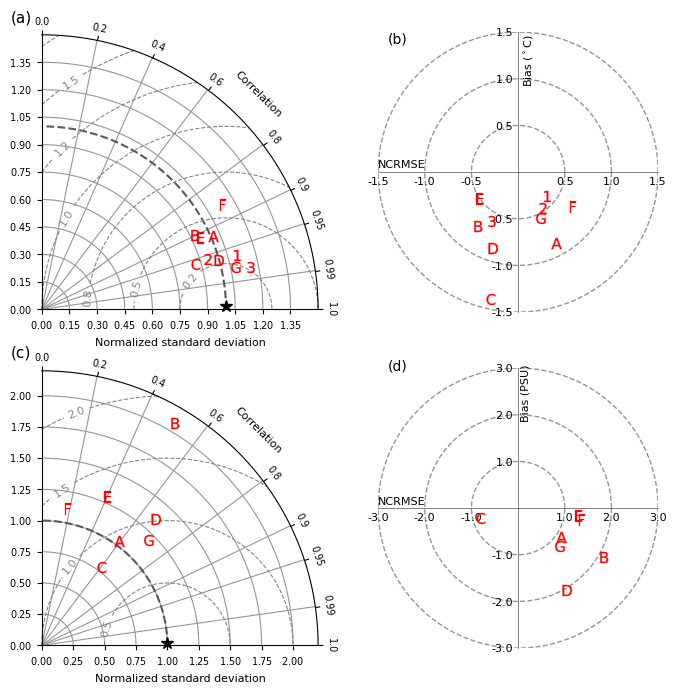

In [21]:
# WARNING - do not analyze experimental runs combined with full hindcast - the labelling etc is not set up yet
# so that short runs with fewer stations and markers will work. 
# - to do: I added a 'experiment' option to the dictionary but I need to actually implement


## streamline the above
modelruns_info = {#'SalishSea1500-RUN203': {'path': 'D:/temp_nemo/RUN203_PLOTS_SCORES/',
#                                             'colour': 'k', 
#                                             'shortcode': 'RUN203', 'experiment': False}, 
#                        'SalishSea1500-RUN216': {'path': 'D:/temp_nemo/RUN216/',
#                                              'colour': 'k', 
#                                             'shortcode': 'RUN216', 'experiment': False},
                      'SalishSea1500-RUN216-altSST': {'path': 'D:/temp_nemo/RUN216_altSST/',
                                             'colour': 'r', 
                                            'shortcode': 'RUN216', 'experiment': False}#,
#                      'SalishSea500-201905': {'path': 'D:/temp_nemo/SS500/',
#                                            'colour': 'g', 
#                                            'shortcode': '201905', 'experiment': True}
                  }

buoy_list = ['46131', '46134', '46146'] # excluding many of these
msize = 8

# set up markers and related options

o_markers = {'active_pass_LH.nc': {'symbol':r'$\mathdefault{A}$','size':msize, 'label':'Active Pass'},
         'cape_mudge_LH.nc': {'symbol':r'$\mathdefault{B}$','size':msize, 'label':'Cape Mudge'},
         'chrome_island_LH.nc': {'symbol':r'$\mathdefault{C}$','size':msize, 'label':'Chrome Is.'},
         'entrance_island_LH.nc': {'symbol':r'$\mathdefault{D}$','size':msize, 'label':'Entrance Is.'},
         'race_rocks_LH.nc': {'symbol':r'$\mathdefault{E}$','size':msize, 'label':'Race Rocks'},
         'sheringham_point_LH.nc': {'symbol':r'$\mathdefault{F}$','size':msize, 'label':'Sheringham Pt.'},
         'sisters_islets_LH.nc': {'symbol':r'$\mathdefault{G}$','size':msize, 'label':'Sisters Islets'},
         # SST / wave buoys (others not used are ptaw1, ptww1,tcnw1,neaw1,46087,46088)
         '46131': {'symbol':"$1$",'size':msize, 'label':'46131'},
         '46146': {'symbol':"$3$",'size':msize, 'label':'46146'},
         '46134': {'symbol':"$2$",'size':msize, 'label':'46134'}
        }


# short runs only have these stations - 2023-08-04
# o_markers = {'chrome_island_LH.nc': {'symbol':r'$\mathdefault{C}$','size':msize, 'label':'Chrome Is.'},
#          'entrance_island_LH.nc': {'symbol':r'$\mathdefault{D}$','size':msize, 'label':'Entrance Is.'},
#          'race_rocks_LH.nc': {'symbol':r'$\mathdefault{E}$','size':msize, 'label':'Race Rocks'},
         
#          # SST / wave buoys (others not used are ptaw1, ptww1,tcnw1,neaw1,46087,46088)
#          '46131': {'symbol':"$1$",'size':msize, 'label':'46131'},
#          '46146': {'symbol':"$3$",'size':msize, 'label':'46146'},
#          '46134': {'symbol':"$2$",'size':msize, 'label':'46134'}
#         }



# fig setup
#  since tight_layout and constrained layout is broken it is important
#  to get the fig w and h proportions correct else cropping occurs
fig_dim_1 = 8 #w
fig_dim_2 = 8 #h
fig = plt.figure(figsize=(fig_dim_1, fig_dim_2)) #w,h

augment_rmse = True

############################
# Taylor diagrams
############################
var = "temperature"
srange=(0, 1.5)
refstd = 1 # reference std dev
rect = 221 # nrows,ncols,index
contour_levs = 7
clr_std_cntr = '#585858'
gs_on = False # added for experimental gridspec layout

ax1_SST = get_taylor_diagram_axes(fig, rect, refstd, srange, contour_levs, clr_std_cntr, gs_on)
ax1_SST = plot_taylor_data(ax1_SST,modelruns_info,var,augment_rmse,buoy_list,o_markers)
ax1_SST.text(-0.1, 1.08, '(a)', ha='left', va='top', fontsize=11, transform=ax1_SST.transAxes)

var = "salinity"
srange=(0, 2.2)
refstd = 1 # reference std dev
rect = 223 # nrows,ncols,index
contour_levs = 5

ax3_SSS = get_taylor_diagram_axes(fig, rect, refstd, srange, contour_levs, clr_std_cntr, gs_on)
ax3_SSS = plot_taylor_data(ax3_SSS,modelruns_info,var,augment_rmse,buoy_list,o_markers)
ax3_SSS.text(-0.1, 1.08, '(c)', ha='left', va='top', fontsize=11, transform=ax3_SSS.transAxes)

############################
# Target diagrams
############################

var = "temperature"
axismax = 1.5
ocircles_t = [0.5,1,1.5,2.0] # radii circles draw
target_ax_options = {
    'ticklabcolor':'#000000',#'#808080',
    'axesedgecolor': '#525252',
    'bias_label': "Bias ($^\circ$C)",
    'RMSD_label': "NCRMSE",
    'b_lab_rot': 90,
    'fontsizelab': 8,
    'fontsizelab_ticks': 8,
    'rmsd_lab_rot':0,
    'b_lab_pos_yoffset': -0.4,
    'b_lab_pos_xoffset': 0.18,
    'rmsd_lab_pos_yoffset': 0.08,
    'rmsd_lab_pos_xoffset': -3.1,
    'axismax': axismax,
    'ticks': [],
    'xticklabelpos': [],
    'yticklabelpos': [],
    'normalized': 'off',
    'circlecols': None, #dictionary with two possible colors keys ('ticks','tick_labels') or None
    'o_circles': ocircles_t,
    #'circlelinespec':'k--',
    'circlelinespec':'k--',
    'circlestyle': '--', # aka circlelinespec[1:]
    'circlelinewidth': 1, # rcParams.get('lines.linewidth')
    'circlecolor': '#969696', #grey'
    'obsuncertainty': 0,
    'equalaxes': 'on',
    'overlay': 'off',
    'linewidth': 0.5
}

ax2_SST = plt.subplot(2,2,2)
ax2_SST = get_target_diagram_axes(ax2_SST, target_ax_options)

target_m_options = {
        # markers and marker styles etc
        'axismax': axismax,
        'o_markers': o_markers,
        'o_markerstyle': "font", # added by GO - "font" / "symbol"
        'o_markersize': msize, 
        'o_markersymbol': 'o', #'+','o','x','s','d','^','v','p','h','*'
        'o_markercolor': 'b',  # single color to use for all markers (Default: None)
        'o_markercolors': None, # if None, considers 'markercolor' only; dictionary with two colors as keys ('face', 'edge')
    #                             or None. If None or 'markerlegend' == 'on' then
    #                             considers only the value of 'markercolor'. (Default: None)

        'o_markerlabelcolor': 'k',
        'markerdisplayed':'marker', # marker / colorbar
        'markerobs': 'none',
        'markerlegend': 'on', # on / off (actually determines whether dots or labelled points)
        'alpha': 1,
        'stylebias': '-.',
        'numberpanels': None,
        'face': None, # face colors'
        'edge': None, 
        'cmap': 'jet',
        'cmap_vmin': None,
        'cmap_vmax': None,
        'cmap_marker': 'd',
        'cmapzdata': [],
        'colframe': '#000000', # black
        'colormap': 'on',
        'labelweight': 'bold', # weight of the x/y labels ('light', 'normal', 'bold', ...)
        'locationcolorbar': 'NorthOutside', # 'NorthOutside' or 'EastOutside'
        'target_options_file':'',
        'titlecolorbar': ''  
    }

ax2_SST = plot_target_data1(ax2_SST,modelruns_info,var,augment_rmse, target_m_options)
ax2_SST.text(-1.4, 1.5, '(b)', ha='left', va='top', fontsize=10)


var = "salinity"
axismax = 3

# change some options
target_ax_options['axismax'] = axismax
target_ax_options['bias_label'] = "Bias (PSU)"
target_ax_options['o_circles'] = [1.0,2.0,3.0]
target_ax_options['b_lab_pos_yoffset'] = -0.7
target_ax_options['b_lab_pos_xoffset'] = 0.26
target_ax_options['rmsd_lab_pos_yoffset'] = 0.15
target_ax_options['rmsd_lab_pos_xoffset'] = -6.2

ax4_SSS = plt.subplot(2,2,4)
ax4_SSS = get_target_diagram_axes(ax4_SSS, target_ax_options)

target_m_options['axismax'] = axismax
ax4_SSS = plot_target_data1(ax4_SSS,modelruns_info,var,augment_rmse, target_m_options)
ax4_SSS.text(-2.8, 3.2, '(d)', ha='left', va='top', fontsize=10)


### CTD Target panel

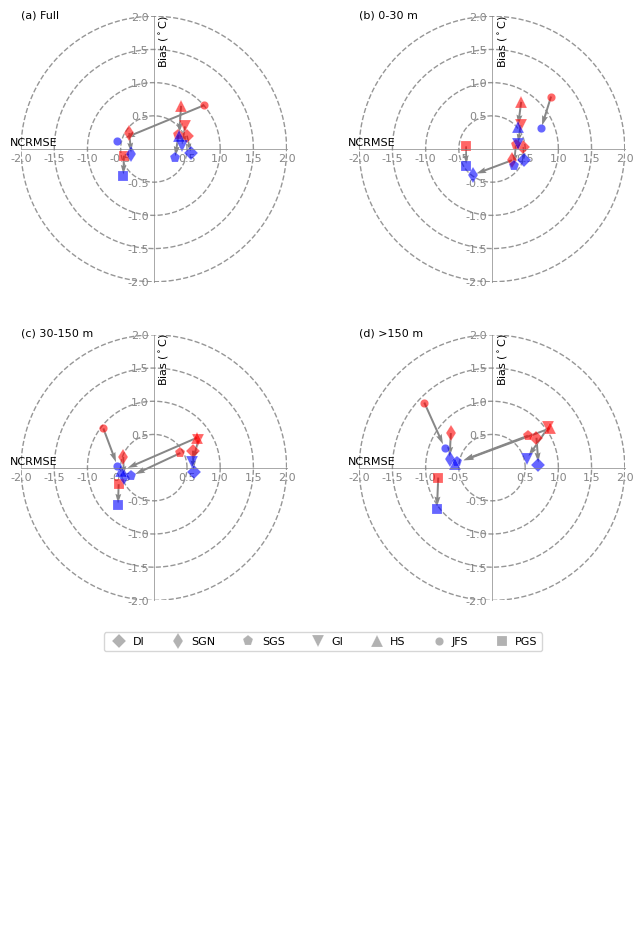

In [8]:
import pandas as pd
import warnings

# get CTD stats for taylor and target figs
def get_CTD_stats(modelrun, path1, dl, var_ts):

    CTD_f = modelrun + '_meanmetricssummary_fewdepths.csv' # produced in other notebook from class4
    
#     with open(os.path.join(path1,CTD_f), 'rb') as fid:
#         CTD_scores = pickle.load(fid)
    
    df = pd.read_csv(os.path.join(path1,CTD_f), index_col=0)  

#     df = pd.DataFrame(data=CTD_scores[1:,1:],
#                                  index=CTD_scores[1:,0],
#                                  columns=CTD_scores[0,1:])
  
    dl = '_' + dl
    df = df.loc[df.index.str.contains(dl)] # get only the rows for depth cat
    var_c_nms = var_ts + '_'
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        mask = df.columns.str.contains(rf'({var_c_nms}|sdom)') # get only ('T_' or' 'S_')
    df = df.loc[:,mask] # selects mask for var

    return df

# following karna, ncrmse can be augmented with sign of std_mod - std_obs
def adjust_rmse(df, var):
    df[var + '_std_mod-obs'] = df[var + '_std_mod'] - df[var + '_std_obs']
    df.loc[df[var + '_std_mod-obs'] < 0, var + '_ncrmse'] = df[var + '_ncrmse'] * -1

    return df

######################################
ocircles_t = [0.5,1,1.5,2.0] # radii circles draw
axismax=2


######################################
modelruns_info = {'SalishSea1500-RUN203': {'path': 'D:/nemo_outputs/ANALYSIS/SalishSea1500-RUN203/PROCESS/CTD/',
                                           'colour': 'r','shortcode': 'RUN203'},
                  'SalishSea1500-RUN216': {'path': 'D:/nemo_outputs/ANALYSIS/SalishSea1500-RUN216/PROCESS/CTD/',
                                           'colour': 'b','shortcode': 'RUN216'}
                 }
msize = 8


target_ax_options = {
    'ticklabcolor':'#858585',#'#808080',
    'axesedgecolor': '#858585', #'#525252'
    'bias_label': "Bias ($^\circ$C)",
    'RMSD_label': "NCRMSE",
    'b_lab_rot': 90,
    'fontsizelab': 8,
    'fontsizelab_ticks': 8,
    'rmsd_lab_rot':0,
    'b_lab_pos_yoffset': -0.5,
    'b_lab_pos_xoffset': 0.18,
    'rmsd_lab_pos_yoffset': 0.1,
    'rmsd_lab_pos_xoffset': -4,
    'axismax': axismax,
    'ticks': [],
    'xticklabelpos': [],
    'yticklabelpos': [],
    'normalized': 'off',
    'circlecols': None, #dictionary with two possible colors keys ('ticks','tick_labels') or None
    'o_circles': ocircles_t,
    #'circlelinespec':'k--',
    'circlelinespec':'k--',
    'circlestyle': '--', # aka circlelinespec[1:]
    'circlelinewidth': 1, # rcParams.get('lines.linewidth')
    'circlecolor': '#969696', #grey'
    'obsuncertainty': 0,
    'equalaxes': 'on',
    'overlay': 'off',
    'linewidth': 0.5
}


# set up markers and related options https://matplotlib.org/stable/api/markers_api.html
o_markers = {'DI': {'symbol':'D','size':msize-1,'label':'DI'},
         'SGN': {'symbol':'d','size':msize,'label':'SGN'},
         'SGS': {'symbol':'p','size':msize,'label':'SGS'},
         'GI': {'symbol':'v','size':msize,'label':'GI'},
         'HS': {'symbol':'^','size':msize,'label':'HS'},
         'JFS': {'symbol':'.','size':msize+4,'label':'JFS'},
         'PGS': {'symbol':'s','size':msize-1,'label':'PGS'}
        }

target_m_options = {
        # markers and marker styles etc
        'axismax': axismax,
        'o_markers': o_markers,
        'o_markerstyle': "font", # added by GO - "font" / "symbol"
        'o_markersize': msize, 
        'o_markersymbol': 'o', #'+','o','x','s','d','^','v','p','h','*'
        'o_markercolor': 'b',  # single color to use for all markers (Default: None)
        'o_markercolors': None, # if None, considers 'markercolor' only; dictionary with two colors as keys ('face', 'edge')
    #                             or None. If None or 'markerlegend' == 'on' then
    #                             considers only the value of 'markercolor'. (Default: None)

        'o_markerlabelcolor': 'k',
        'markerdisplayed':'marker', # marker / colorbar
        'markerobs': 'none',
        'markerlegend': 'on', # on / off (actually determines whether dots or labelled points)
        'alpha': 1,
        'stylebias': '-.',
        'numberpanels': None,
        'face': None, # face colors'
        'edge': None, 
        'cmap': 'jet',
        'cmap_vmin': None,
        'cmap_vmax': None,
        'cmap_marker': 'd',
        'cmapzdata': [],
        'colframe': '#000000', # black
        'colormap': 'on',
        'labelweight': 'bold', # weight of the x/y labels ('light', 'normal', 'bold', ...)
        'locationcolorbar': 'NorthOutside', # 'NorthOutside' or 'EastOutside'
        'target_options_file':'',
        'titlecolorbar': ''  
    }





# made this redundant
# o_markerlabel = ['DI', 'SGN', 'SGS', 'GI', 'HS', 'PS', 'JFS']

# fig setup
#  since tight_layout and constrained layout is broken it is important
#  to get the fig w and h proportions correct else cropping occurs
fig_dim_1 = 8   #w
fig_dim_2 = 20  #h
# fig = plt.figure(figsize=(fig_dim_1, fig_dim_2), layout="constrained") #w,h
fig = plt.figure(figsize=(fig_dim_1, fig_dim_2))#, layout="constrained") #w,h

augment_rmse = True

# for each depth category
sdomains = ['DI','SGN','SGS','GI','HS','JFS','PS']
stats=['bias', 'rmse', 'crmse', 'skill1981', 'mean_obs', 'mean_mod', 'std_obs', 'std_mod']
# dep_levs = ['Full', '0->2', '2->10', '10->30', '30->50', '50->100', '100->200', '200->400'] # omittin nans in  '>400'
# dl_labs = ['Full', '0-2 m', '2-10 m', '10-30 m', '30-50 m', '50-100 m', '100-200 m', '200-400 m']

dep_levs = ['Full', '0->30', '30->150', '>150']
dl_labs = ['Full', '0-30 m', '30-150 m', '>150 m']


var_ts = ['T','S']
var = 'T'

target_ax_options['fontsizelab'] = 8
target_m_options['o_markers'] = o_markers
target_m_options['o_markersize'] = 8
target_m_options['alpha'] = 0.6


edgecolor1 = 'w'
medgew1 = 0.2

# plot for each dep w/ markers for each model / run - get the data and make a targ plot
ax_n = 0
ax_l = ['a','b','c','d','e','f','g','h']
for dl in dep_levs:

    ax_n += 1
    ax_tg = plt.subplot(4+1,2,ax_n) # 4+1 rows 2 cols (last row for legend)
    
    # adjust options
    if var == 'T':
        target_ax_options['axismax'] = 2
        target_ax_options['bias_label'] = "Bias ($^\circ$C)"
        target_ax_options['o_circles'] = [0.5,1,1.5,2.0]
        target_ax_options['b_lab_pos_yoffset'] = -0.5
        target_ax_options['b_lab_pos_xoffset'] = 0.25
        target_ax_options['rmsd_lab_pos_yoffset'] = 0.1
        target_ax_options['rmsd_lab_pos_xoffset'] = -4.3
        
        target_m_options['axismax'] = 2
        
    elif var == 'S':
        target_ax_options['axismax'] = 3
        target_ax_options['bias_label'] = "PSU"
        target_ax_options['o_circles'] = [1.0,2.0,3.0]
        target_ax_options['b_lab_pos_yoffset'] = -0.7
        target_ax_options['b_lab_pos_xoffset'] = 0.26
        target_ax_options['rmsd_lab_pos_yoffset'] = 0.15
        target_ax_options['rmsd_lab_pos_xoffset'] = -6
        
        target_m_options['axismax'] = 3
        
    ax_tg = get_target_diagram_axes(ax_tg, target_ax_options)

    m = 0
    for modelrun in modelruns_info.keys():
        path1 = modelruns_info[modelrun]['path']
        facecolor1 = modelruns_info[modelrun]['colour']
        
        
        CTD_scores_df = get_CTD_stats(modelrun, path1, dl, var)
        if augment_rmse == True:
            CTD_scores_df = adjust_rmse(CTD_scores_df, var)
        Bs, RMSDs = CTD_scores_df.loc[:, var + '_bias'], CTD_scores_df.loc[:, var + '_ncrmse']
        sdoms = CTD_scores_df['sdom']

        ax_tg, handles, labels = plot_target_data2(ax_tg,RMSDs,Bs,target_m_options, facecolor1, edgecolor1, medgew1)
        if m == 0: 
            # store bs and cnrmse for arrows
            Bs_strt = Bs
            RMSDs_strt = RMSDs
         
        m+=1
        
        # hack to save the legend handles for the 'full' range of depths which should include all domains
        # (otherwise the legend handles don't show some like JFS w/ max dep of 200)
        if ax_n == 1 and m == 1:
            handles_fdep = handles
            labels_fdep = labels
            
    ax_tg.quiver(RMSDs_strt, Bs_strt, (RMSDs - RMSDs_strt), (Bs-Bs_strt), angles='xy', scale_units='xy', scale=1.1, 
                 color='#878787', headwidth=3, minshaft=2)   
    ax_tg.text(-2, 2.1, f'({ax_l[ax_n-1]}) {dl_labs[ax_n-1]}', ha='left', va='top', fontsize=8)
    

ax_leg = plt.subplot(4+1,2,6)
ax_leg.axes.get_xaxis().set_visible(False)
ax_leg.axes.get_yaxis().set_visible(False)
ax_leg.spines['top'].set_visible(False)
ax_leg.spines['right'].set_visible(False)
ax_leg.spines['bottom'].set_visible(False)
ax_leg.spines['left'].set_visible(False)

leg = ax_leg.legend(handles_fdep, labels_fdep, loc="upper center", ncol=8,bbox_to_anchor=(-0.1,1.1), 
                    handletextpad=0.2, fontsize=8) #  bbox_to_anchor=(0.3,0.3)

# if more than one model, change leg entries to grey
# note the args for legendhandles are not well documented but anything sent to ax.plot can 
# probably be set
if len(modelruns_info.keys()) > 1:
    for n in range(0,len(leg.legendHandles[:])):
        leg.legendHandles[n].set_color('white') # hide line through each entry
        leg.legendHandles[n].set_markerfacecolor('grey')
        
else:
    for n in range(0,len(leg.legendHandles[:])):
        leg.legendHandles[n].set_color('white')



In [22]:
CTD_scores_df

,sdom,T_mean_mod,T_mean_obs,T_bias,T_std_mod,T_std_obs,T_rmse,T_crmse,T_nrmse,T_ncrmse,T_pears,T_wss,T_std_mod-obs
DI_>150,DI,9.34,9.29,0.05,0.48,0.47,0.34,0.33,0.71,0.70,0.76,0.86,0.01
SGN_>150,SGN,9.27,9.13,0.14,0.33,0.43,0.32,0.29,0.73,-0.66,0.75,0.82,-0.10
SGS_>150,SGS,9.23,9.13,0.10,0.47,0.57,0.32,0.31,0.57,-0.54,0.84,0.90,-0.10
GI_>150,GI,8.78,8.65,0.13,0.67,0.68,0.38,0.36,0.55,-0.52,0.86,0.92,-0.01
HS_>150,HS,8.69,8.62,0.06,0.55,0.60,0.35,0.34,0.58,-0.57,0.83,0.90,-0.05
JFS_>150,JFS,7.37,7.08,0.29,0.53,0.61,0.52,0.43,0.86,-0.72,0.72,0.79,-0.08
PS_>150,PS,11.18,11.80,-0.63,0.34,0.49,0.75,0.41,1.53,-0.84,0.56,0.55,-0.15


In [9]:
CTD_scores_df

,sdom,T_mean_mod,T_mean_obs,T_bias,T_std_mod,T_std_obs,T_rmse,T_crmse,T_nrmse,T_ncrmse,T_pears,T_wss,T_std_mod-obs
DI_>150,DI,9.34,9.29,0.04,0.48,0.47,0.33,0.33,0.71,0.70,0.76,0.86,0.01
SGN_>150,SGN,9.25,9.12,0.13,0.34,0.43,0.31,0.28,0.71,-0.64,0.77,0.83,-0.09
SGS_>150,SGS,9.21,9.13,0.08,0.47,0.57,0.31,0.30,0.54,-0.52,0.85,0.91,-0.10
GI_>150,GI,8.78,8.65,0.13,0.68,0.68,0.38,0.36,0.55,0.52,0.86,0.92,0.00
HS_>150,HS,8.69,8.63,0.06,0.55,0.61,0.35,0.34,0.57,-0.56,0.83,0.90,-0.06
JFS_>150,JFS,7.37,7.08,0.29,0.53,0.61,0.52,0.43,0.86,-0.71,0.72,0.79,-0.08
PS_>150,PS,11.18,11.81,-0.63,0.33,0.49,0.75,0.41,1.52,-0.83,0.57,0.55,-0.16


In [6]:
Bs

DI_>150     4.55
SGN_>150    1.66
SGS_>150    2.27
GI_>150     0.85
HS_>150     0.74
JFS_>150    1.71
PS_>150     4.24
Name: T_bias, dtype: float64

In [23]:
Bs

DI_>150     0.05
SGN_>150    0.14
SGS_>150    0.10
GI_>150     0.13
HS_>150     0.06
JFS_>150    0.29
PS_>150    -0.63
Name: T_bias, dtype: float64

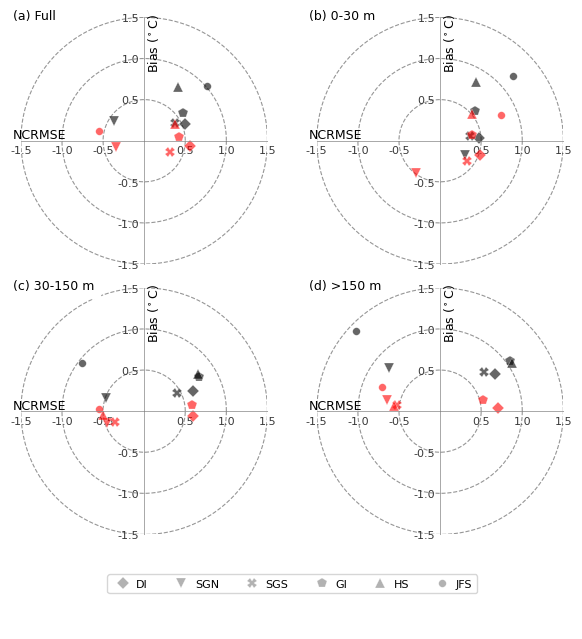

In [10]:
# alt to above using grid spec


######################################
ocircles_t = [0.5,1,1.5,2.0] # radii circles draw
axismax=2

target_ax_options = {
    'ticklabcolor':'#383838',#'#808080',858585 818589
    'axesedgecolor': '#858585', #'#525252'858585
    'bias_label': "Bias ($^\circ$C)",
    'RMSD_label': "NCRMSE",
    'b_lab_rot': 90,
    'fontsizelab': 8,
    'fontsizelab_ticks': 8,
    'rmsd_lab_rot':0,
    'b_lab_pos_yoffset': -0.5,
    'b_lab_pos_xoffset': 0.18,
    'rmsd_lab_pos_yoffset': 0.1,
    'rmsd_lab_pos_xoffset': -4,
    'axismax': axismax,
    'ticks': [],
    'xticklabelpos': [],
    'yticklabelpos': [],
    'normalized': 'off',
    'circlecols': None, #dictionary with two possible colors keys ('ticks','tick_labels') or None
    'o_circles': ocircles_t,
    #'circlelinespec':'k--',
    'circlelinespec':'k--',
    'circlestyle': '--', # aka circlelinespec[1:]
    'circlelinewidth': 0.8, # rcParams.get('lines.linewidth')
    'circlecolor': '#969696', #grey'
    'obsuncertainty': 0,
    'equalaxes': 'on',
    'overlay': 'off',
    'linewidth': 0.5
}

target_m_options = {
        # markers and marker styles etc
        'axismax': axismax,
        'o_markers': o_markers,
        'o_markerstyle': "font", # added by GO - "font" / "symbol"
        'o_markersize': msize, 
        'o_markersymbol': 'o', #'+','o','x','s','d','^','v','p','h','*'
        'o_markercolor': 'b',  # single color to use for all markers (Default: None)
        'o_markercolors': None, # if None, considers 'markercolor' only; dictionary with two colors as keys ('face', 'edge')
    #                             or None. If None or 'markerlegend' == 'on' then
    #                             considers only the value of 'markercolor'. (Default: None)

        'o_markerlabelcolor': 'k',
        'markerdisplayed':'marker', # marker / colorbar
        'markerobs': 'none',
        'markerlegend': 'on', # on / off (actually determines whether dots or labelled points)
        'alpha': 1,
        'stylebias': '-.',
        'numberpanels': None,
        'face': None, # face colors'
        'edge': None, 
        'cmap': 'jet',
        'cmap_vmin': None,
        'cmap_vmax': None,
        'cmap_marker': 'd',
        'cmapzdata': [],
        'colframe': '#000000', # black
        'colormap': 'on',
        'labelweight': 'bold', # weight of the x/y labels ('light', 'normal', 'bold', ...)
        'locationcolorbar': 'NorthOutside', # 'NorthOutside' or 'EastOutside'
        'target_options_file':'',
        'titlecolorbar': ''  
    }



######################################
modelruns_info = {'SalishSea1500-RUN203': {'path': 'D:/nemo_outputs/ANALYSIS/SalishSea1500-RUN203/PROCESS/CTD/',
                                           'colour': 'k','shortcode': 'RUN203'},
                  'SalishSea1500-RUN216': {'path': 'D:/nemo_outputs/ANALYSIS/SalishSea1500-RUN216/PROCESS/CTD/',
                                           'colour': 'r','shortcode': 'RUN216'}
                 }
msize = 7

# set up markers and related options https://matplotlib.org/stable/api/markers_api.html
o_markers = {'DI': {'symbol':'D','size':msize-1,'label':'DI'},
         'SGN': {'symbol':'v','size':msize,'label':'SGN'},
         'SGS': {'symbol':'X','size':msize,'label':'SGS'},
         'GI': {'symbol':'p','size':msize,'label':'GI'},
         'HS': {'symbol':'^','size':msize,'label':'HS'},
         'JFS': {'symbol':'.','size':msize+4,'label':'JFS'}#,
         #'PS': {'symbol':'s','size':msize-1,'label':'PS'}
        }

augment_rmse = True
quiver = 'off'

# for each depth category
sdomains = ['DI','SGN','SGS','GI','HS','JFS'] # omitting PS
stats=['bias', 'rmse', 'crmse', 'skill1981', 'mean_obs', 'mean_mod', 'std_obs', 'std_mod']

# dep_levs = ['Full', '0->2', '2->10', '10->30', '30->50', '50->100', '100->200', '200->400'] # omittin nans in  '>400'
# dl_labs = ['Full', '0-2 m', '2-10 m', '10-30 m', '30-50 m', '50-100 m', '100-200 m', '200-400 m']

dep_levs = ['Full', '0->30', '30->150', '>150']
dl_labs = ['Full', '0-30 m', '30-150 m', '>150 m']

var_ts = ['T','S']
var = 'T'

target_ax_options['fontsizelab'] = 9
target_m_options['o_markers'] = o_markers
target_m_options['o_markersize'] = 8
target_m_options['alpha'] = 0.6


edgecolor1 = 'w'
medgew1 = 0.3

fig_dim_1 = 7   #w
fig_dim_2 = 8  #h
# fig = plt.figure(figsize=(fig_dim_1, fig_dim_2), layout="constrained") #w,h
fig = plt.figure(figsize=(fig_dim_1, fig_dim_2))#, layout="constrained") #w,h

# to get the legend to work, using a grid spec
#  where plots are 4 x tall as legend
gs = gridspec.GridSpec(7, 2) #r, c

# plot for each dep w/ markers for each model / run - get the data and make a targ plot
ax_n = 0
ax_l = ['a','b','c','d','e','f','g','h']
for dl in dep_levs:

    ax_n += 1
    # for 3 x 3 grid layout
#     if ax_n < 4:
#         ax_tg = plt.subplot(gs[0,ax_n-1]) 
#     elif ax_n >= 4 and ax_n < 7:
#         ax_tg = plt.subplot(gs[1,ax_n-4])
#     else:
#         ax_tg = plt.subplot(gs[2, ax_n-7])
        
    if ax_n < 3:
        ax_tg = plt.subplot(gs[0:3,ax_n-1]) 
    elif ax_n >= 3 and ax_n < 5:
        ax_tg = plt.subplot(gs[3:6,ax_n-3])
    else:
        ax_tg = plt.subplot(gs[6:, ax_n-5])
        
    # adjust options
    if var == 'T':
        target_ax_options['axismax'] = 1.5
        target_ax_options['bias_label'] = "Bias ($^\circ$C)"
        target_ax_options['o_circles'] = [0.5,1,1.5]
        target_ax_options['b_lab_pos_yoffset'] = -0.4 #-0.6
        target_ax_options['b_lab_pos_xoffset'] = 0.2 #0.2
        target_ax_options['rmsd_lab_pos_yoffset'] = 0.1
        target_ax_options['rmsd_lab_pos_xoffset'] = -3.2 #-4.3
        
        target_m_options['axismax'] = 2
        
    elif var == 'S':
        target_ax_options['axismax'] = 3
        target_ax_options['bias_label'] = "Bias PSU"
        target_ax_options['o_circles'] = [1.0,2.0,3.0]
        target_ax_options['b_lab_pos_yoffset'] = -0.7
        target_ax_options['b_lab_pos_xoffset'] = 0.26
        target_ax_options['rmsd_lab_pos_yoffset'] = 0.15
        target_ax_options['rmsd_lab_pos_xoffset'] = -6
        
        target_m_options['axismax'] = 3
        
    ax_tg = get_target_diagram_axes(ax_tg, target_ax_options)

    m = 0
    for modelrun in modelruns_info.keys():
        path1 = modelruns_info[modelrun]['path']
        facecolor1 = modelruns_info[modelrun]['colour']
        
        
        CTD_scores_df = get_CTD_stats(modelrun, path1, dl, var)
        if augment_rmse == True:
            CTD_scores_df = adjust_rmse(CTD_scores_df, var)
        CTD_scores_df = CTD_scores_df.loc[CTD_scores_df['sdom'].isin(sdomains)]
        Bs, RMSDs = CTD_scores_df.loc[:, var + '_bias'], CTD_scores_df.loc[:, var + '_ncrmse'] 
        sdoms = CTD_scores_df['sdom'] # not used yet GO 202308

        ax_tg, handles, labels = plot_target_data2(ax_tg,RMSDs,Bs,target_m_options, facecolor1, edgecolor1, medgew1)
        if m == 0: 
            # store bs and cnrmse for arrows
            Bs_strt = Bs
            RMSDs_strt = RMSDs
         
        m+=1
        
        # hack to save the legend handles for the 'full' range of depths which should include all domains
        # (otherwise the legend handles don't show some like JFS w/ max dep of 200)
        if ax_n == 1 and m == 1:
            handles_fdep = handles
            labels_fdep = labels
    if quiver == 'on':     
        ax_tg.quiver(RMSDs_strt, Bs_strt, (RMSDs - RMSDs_strt), (Bs-Bs_strt), angles='xy', scale_units='xy', scale=1.1, 
                     color='#878787', headwidth=3, minshaft=2)   
#     ax_tg.text(-2.2, 2.0, f'({ax_l[ax_n-1]}) {dl_labs[ax_n-1]}', ha='left', va='top', fontsize=10)
    ax_tg.text(-1.6, 1.6, f'({ax_l[ax_n-1]}) {dl_labs[ax_n-1]}', ha='left', va='top', fontsize=9, 
               backgroundcolor='w', zorder=10)
    

ax_leg = plt.subplot(gs[6:, 0:1])

# works for 3 x 3 layout
# leg = ax_leg.legend(handles_fdep, labels_fdep, loc="center", ncol=1, 
#                     handletextpad=0.2, fontsize=8) #  bbox_to_anchor=(0.3,0.3)
leg = ax_leg.legend(handles_fdep, labels_fdep, loc="upper center", ncol=8, 
                    handletextpad=0.2, fontsize=8, bbox_to_anchor=(1.1,0.8))

# if more than one model, change leg entries to grey
# note the args for legendhandles are not well documented but anything sent to ax.plot can 
# probably be set
if len(modelruns_info.keys()) > 1:
    for n in range(0,len(leg.legendHandles[:])):
        leg.legendHandles[n].set_color('white') # hide line through each entry
        leg.legendHandles[n].set_markerfacecolor('grey')
        
else:
    for n in range(0,len(leg.legendHandles[:])):
        leg.legendHandles[n].set_color('white')


ax_leg.axes.get_xaxis().set_visible(False)
ax_leg.axes.get_yaxis().set_visible(False)
ax_leg.spines['top'].set_visible(False)
ax_leg.spines['right'].set_visible(False)
ax_leg.spines['bottom'].set_visible(False)
ax_leg.spines['left'].set_visible(False)



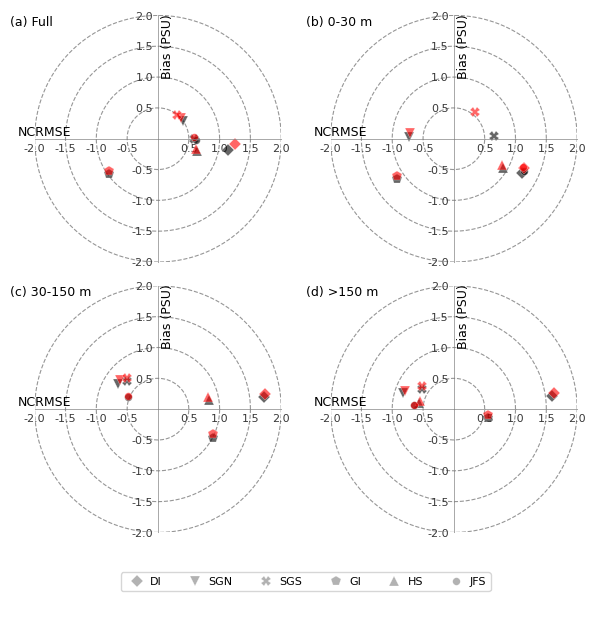

In [18]:
# alt to above using grid spec


######################################
ocircles_t = [0.5,1,1.5,2.0] # radii circles draw
axismax=2

target_ax_options = {
    'ticklabcolor':'#383838',#'#808080',858585 818589
    'axesedgecolor': '#858585', #'#525252'858585
    'bias_label': "Bias ($^\circ$C)",
    'RMSD_label': "NCRMSE",
    'b_lab_rot': 90,
    'fontsizelab': 8,
    'fontsizelab_ticks': 8,
    'rmsd_lab_rot':0,
    'b_lab_pos_yoffset': -0.5,
    'b_lab_pos_xoffset': 0.18,
    'rmsd_lab_pos_yoffset': 0.1,
    'rmsd_lab_pos_xoffset': -4,
    'axismax': axismax,
    'ticks': [],
    'xticklabelpos': [],
    'yticklabelpos': [],
    'normalized': 'off',
    'circlecols': None, #dictionary with two possible colors keys ('ticks','tick_labels') or None
    'o_circles': ocircles_t,
    #'circlelinespec':'k--',
    'circlelinespec':'k--',
    'circlestyle': '--', # aka circlelinespec[1:]
    'circlelinewidth': 0.8, # rcParams.get('lines.linewidth')
    'circlecolor': '#969696', #grey'
    'obsuncertainty': 0,
    'equalaxes': 'on',
    'overlay': 'off',
    'linewidth': 0.5
}

target_m_options = {
        # markers and marker styles etc
        'axismax': axismax,
        'o_markers': o_markers,
        'o_markerstyle': "font", # added by GO - "font" / "symbol"
        'o_markersize': msize, 
        'o_markersymbol': 'o', #'+','o','x','s','d','^','v','p','h','*'
        'o_markercolor': 'b',  # single color to use for all markers (Default: None)
        'o_markercolors': None, # if None, considers 'markercolor' only; dictionary with two colors as keys ('face', 'edge')
    #                             or None. If None or 'markerlegend' == 'on' then
    #                             considers only the value of 'markercolor'. (Default: None)

        'o_markerlabelcolor': 'k',
        'markerdisplayed':'marker', # marker / colorbar
        'markerobs': 'none',
        'markerlegend': 'on', # on / off (actually determines whether dots or labelled points)
        'alpha': 1,
        'stylebias': '-.',
        'numberpanels': None,
        'face': None, # face colors'
        'edge': None, 
        'cmap': 'jet',
        'cmap_vmin': None,
        'cmap_vmax': None,
        'cmap_marker': 'd',
        'cmapzdata': [],
        'colframe': '#000000', # black
        'colormap': 'on',
        'labelweight': 'bold', # weight of the x/y labels ('light', 'normal', 'bold', ...)
        'locationcolorbar': 'NorthOutside', # 'NorthOutside' or 'EastOutside'
        'target_options_file':'',
        'titlecolorbar': ''  
    }



######################################
modelruns_info = {'SalishSea1500-RUN203': {'path': 'D:/nemo_outputs/ANALYSIS/SalishSea1500-RUN203/PROCESS/CTD/',
                                           'colour': 'k','shortcode': 'RUN203'},
                  'SalishSea1500-RUN216': {'path': 'D:/nemo_outputs/ANALYSIS/SalishSea1500-RUN216/PROCESS/CTD/',
                                           'colour': 'r','shortcode': 'RUN216'}
                 }
msize = 7

# set up markers and related options https://matplotlib.org/stable/api/markers_api.html
o_markers = {'DI': {'symbol':'D','size':msize-1,'label':'DI'},
         'SGN': {'symbol':'v','size':msize,'label':'SGN'},
         'SGS': {'symbol':'X','size':msize,'label':'SGS'},
         'GI': {'symbol':'p','size':msize,'label':'GI'},
         'HS': {'symbol':'^','size':msize,'label':'HS'},
         'JFS': {'symbol':'.','size':msize+4,'label':'JFS'}#,
         #'PS': {'symbol':'s','size':msize-1,'label':'PS'}
        }

augment_rmse = True
quiver = 'off'

# for each depth category
sdomains = ['DI','SGN','SGS','GI','HS','JFS'] # omitting PS
stats=['bias', 'rmse', 'crmse', 'skill1981', 'mean_obs', 'mean_mod', 'std_obs', 'std_mod']

# dep_levs = ['Full', '0->2', '2->10', '10->30', '30->50', '50->100', '100->200', '200->400'] # omittin nans in  '>400'
# dl_labs = ['Full', '0-2 m', '2-10 m', '10-30 m', '30-50 m', '50-100 m', '100-200 m', '200-400 m']

dep_levs = ['Full', '0->30', '30->150', '>150']
dl_labs = ['Full', '0-30 m', '30-150 m', '>150 m']

var_ts = ['T','S']
var = 'S'

target_ax_options['fontsizelab'] = 9
target_m_options['o_markers'] = o_markers
target_m_options['o_markersize'] = 8
target_m_options['alpha'] = 0.6


edgecolor1 = 'w'
medgew1 = 0.3

fig_dim_1 = 7   #w
fig_dim_2 = 8  #h
# fig = plt.figure(figsize=(fig_dim_1, fig_dim_2), layout="constrained") #w,h
fig = plt.figure(figsize=(fig_dim_1, fig_dim_2))#, layout="constrained") #w,h

# to get the legend to work, using a grid spec
#  where plots are 4 x tall as legend
gs = gridspec.GridSpec(7, 2) #r, c

# plot for each dep w/ markers for each model / run - get the data and make a targ plot
ax_n = 0
ax_l = ['a','b','c','d','e','f','g','h']
for dl in dep_levs:

    ax_n += 1
    # for 3 x 3 grid layout
#     if ax_n < 4:
#         ax_tg = plt.subplot(gs[0,ax_n-1]) 
#     elif ax_n >= 4 and ax_n < 7:
#         ax_tg = plt.subplot(gs[1,ax_n-4])
#     else:
#         ax_tg = plt.subplot(gs[2, ax_n-7])
        
    if ax_n < 3:
        ax_tg = plt.subplot(gs[0:3,ax_n-1]) 
    elif ax_n >= 3 and ax_n < 5:
        ax_tg = plt.subplot(gs[3:6,ax_n-3])
    else:
        ax_tg = plt.subplot(gs[6:, ax_n-5])
        
    # adjust options
    if var == 'T':
        target_ax_options['axismax'] = 1.5
        target_ax_options['bias_label'] = "Bias ($^\circ$C)"
        target_ax_options['o_circles'] = [0.5,1,1.5]
        target_ax_options['b_lab_pos_yoffset'] = -0.4 #-0.6
        target_ax_options['b_lab_pos_xoffset'] = 0.2 #0.2
        target_ax_options['rmsd_lab_pos_yoffset'] = 0.1
        target_ax_options['rmsd_lab_pos_xoffset'] = -3.2 #-4.3
        
        target_m_options['axismax'] = 2
        
    elif var == 'S':
        target_ax_options['axismax'] = 2
        target_ax_options['bias_label'] = "Bias (PSU)"
        target_ax_options['o_circles'] = [0.5,1,1.5,2.0]
        target_ax_options['b_lab_pos_yoffset'] = -0.6
        target_ax_options['b_lab_pos_xoffset'] = 0.26
        target_ax_options['rmsd_lab_pos_yoffset'] = 0.15
        target_ax_options['rmsd_lab_pos_xoffset'] = -4.4
        
        target_m_options['axismax'] = 3
        
    ax_tg = get_target_diagram_axes(ax_tg, target_ax_options)

    m = 0
    for modelrun in modelruns_info.keys():
        path1 = modelruns_info[modelrun]['path']
        facecolor1 = modelruns_info[modelrun]['colour']
        
        
        CTD_scores_df = get_CTD_stats(modelrun, path1, dl, var)
        if augment_rmse == True:
            CTD_scores_df = adjust_rmse(CTD_scores_df, var)
        CTD_scores_df = CTD_scores_df.loc[CTD_scores_df['sdom'].isin(sdomains)]
        Bs, RMSDs = CTD_scores_df.loc[:, var + '_bias'], CTD_scores_df.loc[:, var + '_ncrmse'] 
        sdoms = CTD_scores_df['sdom'] # not used yet GO 202308

        ax_tg, handles, labels = plot_target_data2(ax_tg,RMSDs,Bs,target_m_options, facecolor1, edgecolor1, medgew1)
        if m == 0: 
            # store bs and cnrmse for arrows
            Bs_strt = Bs
            RMSDs_strt = RMSDs
         
        m+=1
        
        # hack to save the legend handles for the 'full' range of depths which should include all domains
        # (otherwise the legend handles don't show some like JFS w/ max dep of 200)
        if ax_n == 1 and m == 1:
            handles_fdep = handles
            labels_fdep = labels
    if quiver == 'on':     
        ax_tg.quiver(RMSDs_strt, Bs_strt, (RMSDs - RMSDs_strt), (Bs-Bs_strt), angles='xy', scale_units='xy', scale=1.1, 
                     color='#878787', headwidth=3, minshaft=2)   
    ax_tg.text(-2.4, 2.0, f'({ax_l[ax_n-1]}) {dl_labs[ax_n-1]}', ha='left', va='top', fontsize=9, zorder=10)
#     ax_tg.text(-1.6, 1.6, f'({ax_l[ax_n-1]}) {dl_labs[ax_n-1]}', ha='left', va='top', fontsize=9, 
#                backgroundcolor='w', zorder=10)
    

ax_leg = plt.subplot(gs[6:, 0:1])

# works for 3 x 3 layout
# leg = ax_leg.legend(handles_fdep, labels_fdep, loc="center", ncol=1, 
#                     handletextpad=0.2, fontsize=8) #  bbox_to_anchor=(0.3,0.3)
leg = ax_leg.legend(handles_fdep, labels_fdep, loc="upper center", ncol=8, 
                    handletextpad=0.2, fontsize=8, bbox_to_anchor=(1.1,0.8))

# if more than one model, change leg entries to grey
# note the args for legendhandles are not well documented but anything sent to ax.plot can 
# probably be set
if len(modelruns_info.keys()) > 1:
    for n in range(0,len(leg.legendHandles[:])):
        leg.legendHandles[n].set_color('white') # hide line through each entry
        leg.legendHandles[n].set_markerfacecolor('grey')
        
else:
    for n in range(0,len(leg.legendHandles[:])):
        leg.legendHandles[n].set_color('white')


ax_leg.axes.get_xaxis().set_visible(False)
ax_leg.axes.get_yaxis().set_visible(False)
ax_leg.spines['top'].set_visible(False)
ax_leg.spines['right'].set_visible(False)
ax_leg.spines['bottom'].set_visible(False)
ax_leg.spines['left'].set_visible(False)

In [574]:
CTD_scores_df

,sdom,T_mean_mod,T_mean_obs,T_bias,T_std_mod,T_std_obs,T_rmse,T_crmse,T_nrmse,T_ncrmse,T_pears,T_wss,T_std_mod_rel
DI_>150,DI,9.34,9.29,0.05,0.48,0.47,0.34,0.33,0.71,0.70,0.76,0.86,1.021277
SGN_>150,SGN,9.27,9.13,0.14,0.33,0.43,0.32,0.29,0.73,0.66,0.75,0.82,0.767442
SGS_>150,SGS,9.23,9.13,0.10,0.47,0.57,0.32,0.31,0.57,0.54,0.84,0.90,0.824561
GI_>150,GI,8.78,8.65,0.13,0.67,0.68,0.38,0.36,0.55,0.52,0.86,0.92,0.985294
HS_>150,HS,8.69,8.62,0.06,0.55,0.60,0.35,0.34,0.58,0.57,0.83,0.90,0.916667
JFS_>150,JFS,7.37,7.08,0.29,0.53,0.61,0.52,0.43,0.86,0.72,0.72,0.79,0.868852
PS_>150,PS,11.18,11.80,-0.63,0.34,0.49,0.75,0.41,1.53,0.84,0.56,0.55,0.693878


In [16]:
def plot_taylor_ctd(ax, var, dl, data_for_taylor, o_markers, colour_m):
    
    pairs_stats = []
#     print(len(data_for_taylor))
    # preps an array in format that taylor plotter expects
    # to-do - don't need this loop / structure, it's carried over from old script
    for i in range(len(data_for_taylor)+1):
        if i == 0:
            stn = "reference"
            sig = 1
            cc = 1
        else:
#             stn = o_markerlabel[i-1] # this is problem
            stn = data_for_taylor['sdom'][i-1]
            sig = data_for_taylor[var + '_std_mod_rel'][i-1]
            cc = data_for_taylor[var + '_pears'][i-1]
        pairs_stats.append([stn,[sig,cc]])

    # plot markers
    facecolor1 = colour_m
    facecolor2 = colour_m
    edgecolor1 = colour_m
    edgecolor2 = colour_m
    medgew1 = 0.2
    medgew2 = 0.2


    # Add the model markers to Taylor diagram
    i = 0
    hp = ()
    labels = []
    for i, (stn, stats) in enumerate(pairs_stats):
        # avoid douvble-plotting ref
        if stn == 'reference':
            continue
        stddev = stats[0]
        corrcoef = stats[1]
        marker1 = o_markers[stn]['symbol']

        h = ax.plot(np.arccos(corrcoef), 
                stddev, 
                marker=marker1,
                markersize=o_markers[stn]['size'],
                ls='',
                #mfc=colors[i],
                #mfc=o_markers[stn]['facecolor'],
                mfc=colour_m,
                #mec=colors[i],
                mec=edgecolor1,
                mew=medgew1,
                #label="%d" % (i+1)),
                label=o_markers[stn]['label'], 
                alpha=0.6
               )
        hp += tuple(h)
        labels.append(stn)

    return ax, hp, labels

msize = 7

# set up markers and related options https://matplotlib.org/stable/api/markers_api.html
o_markers = {'DI': {'symbol':'D','size':msize-1,'label':'DI'},
         'SGN': {'symbol':'v','size':msize,'label':'SGN'},
         'SGS': {'symbol':'X','size':msize,'label':'SGS'},
         'GI': {'symbol':'p','size':msize,'label':'GI'},
         'HS': {'symbol':'^','size':msize,'label':'HS'},
         'JFS': {'symbol':'.','size':msize+4,'label':'JFS'}#,
         #'PS': {'symbol':'s','size':msize-1,'label':'PS'}
        }

# taylor panel for CTDs
modelruns_info = {'SalishSea1500-RUN203': {'path': 'D:/nemo_outputs/ANALYSIS/SalishSea1500-RUN203/PROCESS/CTD/',
                                       'colour': 'k','shortcode': 'RUN203'},
                  'SalishSea1500-RUN216': {'path': 'D:/nemo_outputs/ANALYSIS/SalishSea1500-RUN216/PROCESS/CTD/',
                                           'colour': 'r','shortcode': 'RUN216'}
             }

sdomains = ['DI','SGN','SGS','GI','HS','JFS'] # omitting PS

#  since tight_layout and constrained layout is broken it is important
#  to get the fig w and h proportions correct else cropping occurs
fig_dim_1 = 10   #w
fig_dim_2 = 42  #h
fig = plt.figure(figsize=(fig_dim_1, fig_dim_2)) #w,h

var = "T"
srange=(0, 1.6)
refstd = 1 # reference std dev
contour_levs = 4
clr_std_cntr = '#585858'

# plot for each dep w/ markers for each model / run -
ax_n = 0
ax_l = ['a','b','c','d','e','f','g','h']

# gridspec style layout on? 
gs_on = True
for dl in dep_levs:

    ax_n += 1
    rect = 820+ax_n # to-do: figure out if rect can be (,,,) fmt
    ax_ty = get_taylor_diagram_axes(fig, rect, refstd, srange, contour_levs, clr_std_cntr, gs_on)
    
    m = 0
    for modelrun in modelruns_info.keys():
        path1 = modelruns_info[modelrun]['path']
        colour_m = modelruns_info[modelrun]['colour']
    
        CTD_scores_df = get_CTD_stats(modelrun, path1, dl, var)
        CTD_scores_df = CTD_scores_df.loc[CTD_scores_df['sdom'].isin(sdomains)]
        # calc relative std dev
        CTD_scores_df[ var + '_std_mod_rel'] = CTD_scores_df[var + '_std_mod'] / CTD_scores_df[var + '_std_obs']
        data_for_taylor = CTD_scores_df.loc[:, ['sdom',  var + '_std_mod_rel', var + '_pears']]
        
        ax_ty, handles, labels = plot_taylor_ctd(ax_ty, var, dl, data_for_taylor, o_markers, colour_m)
        
        m+=1
        
    ax_ty.text(1.7, 1.8, f'({ax_l[ax_n-1]}) {dl_labs[ax_n-1]}', ha='left', va='top', fontsize=10, fontweight='bold')
        
    #ax_ty = plot_taylor_data(ax_ty,modelruns_info,var,augment_rmse,buoy_list,o_markers,o_markerlabel)
    


TypeError: '<' not supported between instances of 'list' and 'int'

<Figure size 1000x4200 with 0 Axes>

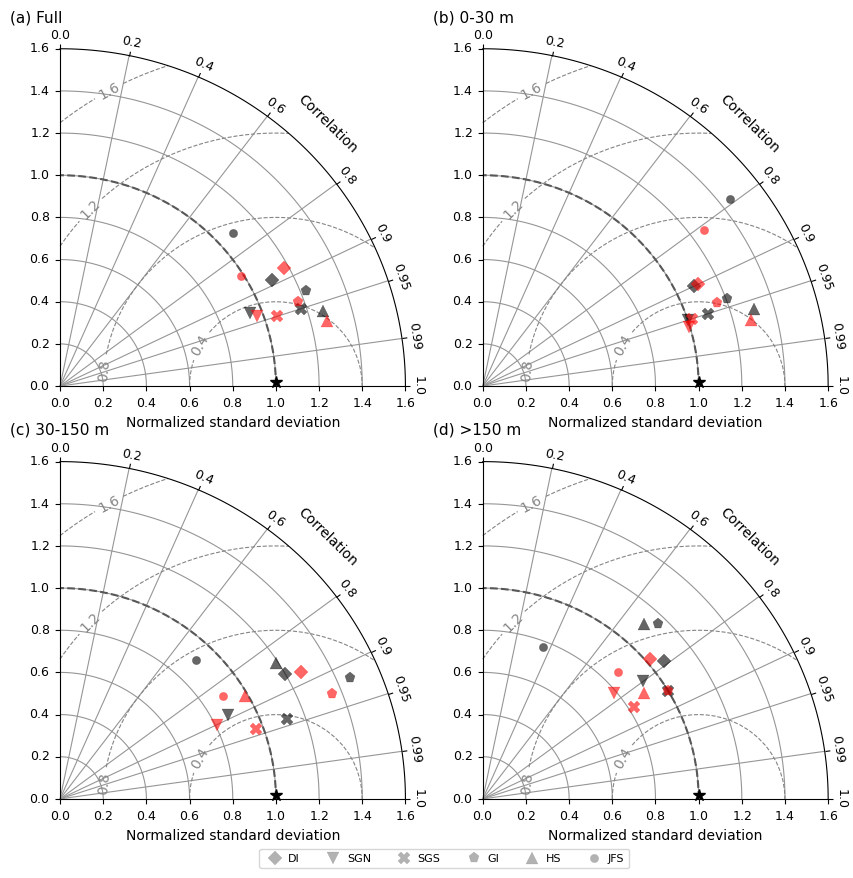

In [63]:
msize = 8

# set up markers and related options https://matplotlib.org/stable/api/markers_api.html
o_markers = {'DI': {'symbol':'D','size':msize-1,'label':'DI'},
         'SGN': {'symbol':'v','size':msize,'label':'SGN'},
         'SGS': {'symbol':'X','size':msize,'label':'SGS'},
         'GI': {'symbol':'p','size':msize,'label':'GI'},
         'HS': {'symbol':'^','size':msize,'label':'HS'},
         'JFS': {'symbol':'.','size':msize+4,'label':'JFS'}#,
#          'PS': {'symbol':'s','size':msize-1,'label':'PGS'}
        }

# taylor panel for CTDs
modelruns_info = {'SalishSea1500-RUN203': {'path': 'D:/nemo_outputs/ANALYSIS/SalishSea1500-RUN203/PROCESS/CTD/',
                                       'colour': 'k','shortcode': 'RUN203'},
                  'SalishSea1500-RUN216': {'path': 'D:/nemo_outputs/ANALYSIS/SalishSea1500-RUN216/PROCESS/CTD/',
                                           'colour': 'r','shortcode': 'RUN216'}
             }

sdomains = ['DI','SGN','SGS','GI','HS','JFS'] # omitting PS

#  since tight_layout and constrained layout is broken it is important
#  to get the fig w and h proportions correct else cropping occurs
fig_dim_1 = 10   #w
fig_dim_2 = 42  #h
fig = plt.figure(figsize=(fig_dim_1, fig_dim_2)) #w,h

var = "T"
if var == "T":
    srange=(0, 1.6) # for T
else:
    srange=(0, 2.4)
refstd = 1 # reference std dev
contour_levs = 4
clr_std_cntr = '#585858'

# plot for each dep w/ markers for each model / run -
ax_n = 0
ax_l = ['a','b','c','d','e','f','g','h']
gs_on = False
for dl in dep_levs:

    ax_n += 1
    rect = 820+ax_n # to-do: figure out if rect can be (,,,) fmt
    ax_ty = get_taylor_diagram_axes(fig, rect, refstd, srange, contour_levs, clr_std_cntr, gs_on)
    
    m = 0
    for modelrun in modelruns_info.keys():
        path1 = modelruns_info[modelrun]['path']
        colour_m = modelruns_info[modelrun]['colour']
    
        CTD_scores_df = get_CTD_stats(modelrun, path1, dl, var)
        # calc relative std dev
        CTD_scores_df = CTD_scores_df.loc[CTD_scores_df['sdom'].isin(sdomains)]
        CTD_scores_df[ var + '_std_mod_rel'] = CTD_scores_df[var + '_std_mod'] / CTD_scores_df[var + '_std_obs']
        data_for_taylor = CTD_scores_df.loc[:, ['sdom',  var + '_std_mod_rel', var + '_pears']]
        
        ax_ty, handles, labels = plot_taylor_ctd(ax_ty, var, dl, data_for_taylor, o_markers, colour_m)
        m+=1
        
        # hack to save the legend handles for the 'full' range of depths which should include all domains
        # (otherwise the legend handles don't show some like JFS w/ max dep of 200)
        if ax_n == 1 and m == 1:
            handles_fdep = handles
            labels_fdep = labels
    
    if var == "T":
        ax_ty.text(1.7, 1.8, f'({ax_l[ax_n-1]}) {dl_labs[ax_n-1]}', ha='left', va='top', fontsize=11) # for T
    else:
        ax_ty.text(1.7, 2.7, f'({ax_l[ax_n-1]}) {dl_labs[ax_n-1]}', ha='left', va='top', fontsize=11) # for S
        
    #ax_ty = plot_taylor_data(ax_ty,modelruns_info,var,augment_rmse,buoy_list,o_markers,o_markerlabel)


leg = ax_ty.legend(handles_fdep, labels_fdep, loc="upper center", ncol=8, bbox_to_anchor=(-0.1,-0.12),
                  handletextpad=0.2, fontsize=8) 
    
# if more than one model, change leg entries to grey
# note the args for legendhandles are not well documented but anything sent to ax.plot can 
# probably be set
if len(modelruns_info.keys()) > 1:
    for n in range(0,len(leg.legendHandles[:])):
        leg.legendHandles[n].set_color('white') # hide line through each entry
        leg.legendHandles[n].set_markerfacecolor('grey')
        leg.legendHandles[n].set_markeredgecolor('grey')
        
else:
    for n in range(0,len(leg.legendHandles[:])):
        leg.legendHandles[n].set_color('white')

# leg = ax_leg.legend(handles_fdep, labels_fdep, loc="upper center", ncol=8, 
#                     handletextpad=0.2, fontsize=8, bbox_to_anchor=(1.1,0.8))

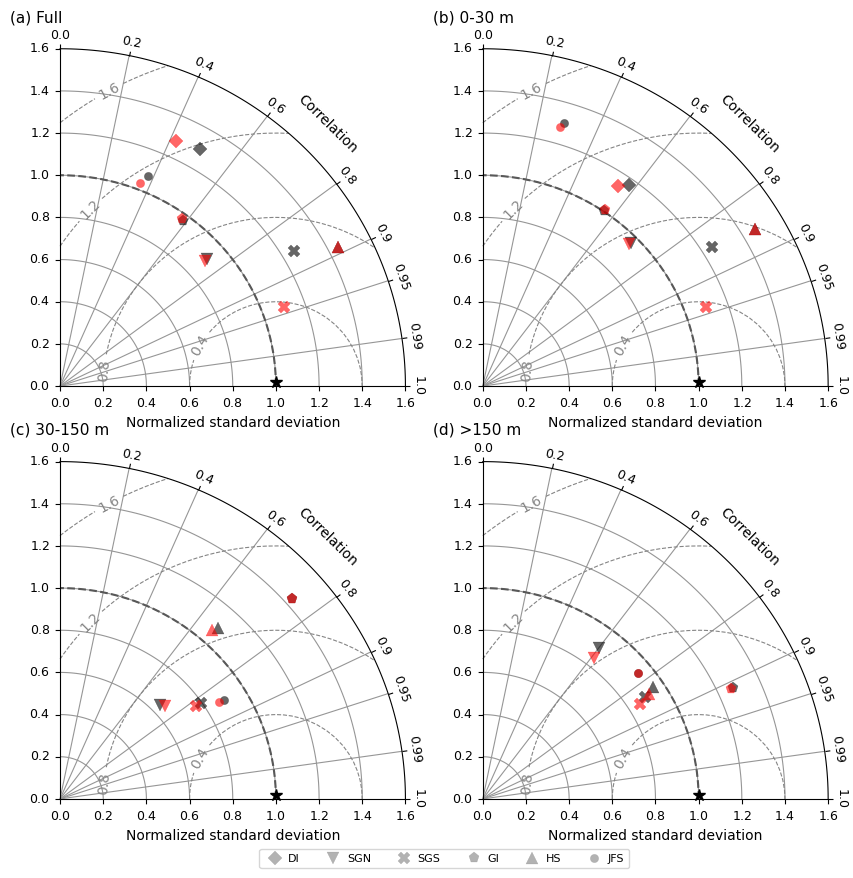

In [62]:
 modelruns_info = {'SalishSea1500-RUN203': {'path': 'D:/temp_nemo/RUN203_PLOTS_SCORES/',
                                       'colour': 'k','shortcode': 'RUN203'},
                  'SalishSea1500-RUN216': {'path': 'D:/temp_nemo/RUN216/',
                                           'colour': 'r','shortcode': 'RUN216'}
             }

#  since tight_layout and constrained layout is broken it is important
#  to get the fig w and h proportions correct else cropping occurs
fig_dim_1 = 10   #w
fig_dim_2 = 42  #h
fig = plt.figure(figsize=(fig_dim_1, fig_dim_2)) #w,h

var = "S"
srange=(0, 1.6)
refstd = 1 # reference std dev
contour_levs = 4
clr_std_cntr = '#585858'

# plot for each dep w/ markers for each model / run -
ax_n = 0
ax_l = ['a','b','c','d','e','f','g','h']
gs_on = False
# gs_col = 
# gs_row = 
for dl in dep_levs:

    ax_n += 1
    rect = 820+ax_n # to-do: figure out if rect can be (,,,) fmt
    ax_ty = get_taylor_diagram_axes(fig, rect, refstd, srange, contour_levs, clr_std_cntr, gs_on)
    
    m = 0
    for modelrun in modelruns_info.keys():
        path1 = modelruns_info[modelrun]['path']
        colour_m = modelruns_info[modelrun]['colour']
    
        CTD_scores_df = get_CTD_stats(modelrun, path1, dl, var)
        CTD_scores_df = CTD_scores_df.loc[CTD_scores_df['sdom'].isin(sdomains)]
        # calc relative std dev
        CTD_scores_df[ var + '_std_mod_rel'] = CTD_scores_df[var + '_std_mod'] / CTD_scores_df[var + '_std_obs']
        data_for_taylor = CTD_scores_df.loc[:, ['sdom',  var + '_std_mod_rel', var + '_pears']]
        
        ax_ty, handles, labels = plot_taylor_ctd(ax_ty, var, dl, data_for_taylor, o_markers, colour_m)
        
        
    ax_ty.text(1.7, 1.8, f'({ax_l[ax_n-1]}) {dl_labs[ax_n-1]}', ha='left', va='top', fontsize=11)
        
    #ax_ty = plot_taylor_data(ax_ty,modelruns_info,var,augment_rmse,buoy_list,o_markers,o_markerlabel)


leg = ax_ty.legend(handles, labels, loc="upper center", ncol=8, bbox_to_anchor=(-0.1,-0.12),
                  handletextpad=0.2, fontsize=8) 
    
# if more than one model, change leg entries to grey
# note the args for legendhandles are not well documented but anything sent to ax.plot can 
# probably be set
if len(modelruns_info.keys()) > 1:
    for n in range(0,len(leg.legendHandles[:])):
        leg.legendHandles[n].set_color('white') # hide line through each entry
        leg.legendHandles[n].set_markerfacecolor('grey')
        leg.legendHandles[n].set_markeredgecolor('grey')
        
else:
    for n in range(0,len(leg.legendHandles[:])):
        leg.legendHandles[n].set_color('white')

# leg = ax_leg.legend(handles_fdep, labels_fdep, loc="upper center", ncol=8, 
#                     handletextpad=0.2, fontsize=8, bbox_to_anchor=(1.1,0.8))

In [572]:
data_for_taylor


,sdom,T_std_mod_rel,T_pears
DI_>150,DI,1.021277,0.76
SGN_>150,SGN,0.767442,0.75
SGS_>150,SGS,0.824561,0.84
GI_>150,GI,0.985294,0.86
HS_>150,HS,0.916667,0.83
JFS_>150,JFS,0.868852,0.72
PS_>150,PS,0.693878,0.56


## epxeriment animation

<IPython.core.display.Javascript object>


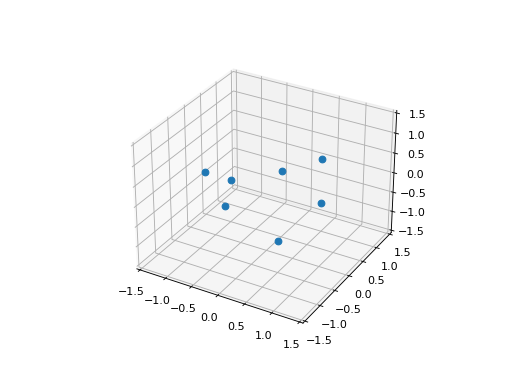

In [334]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

num_of_points = 7
num_of_frames = 50

t=np.linspace(0, 2*np.pi, num_of_frames, endpoint=False)[:, None] + np.linspace(0, 2*np.pi, num_of_points, endpoint=False)[None, :]
x=np.cos(t)
y=np.sin(t)
z=np.sin(t)*np.cos(t)

points, = ax.plot([], [], [], 'o')


def update_points(n):
    points.set_data(np.array([x[n, :], y[n, :]]))
    points.set_3d_properties(z[n, :], 'z')
    return points,

ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
ax.set_zlim([-1.5, 1.5])


ani=animation.FuncAnimation(fig, update_points, num_of_frames, interval=100, blit=True, repeat=True)
plt.show()

In [364]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

n_frames = 200

x=[Bs_strt,Bs]
y=

points, = ax.plot([], [], 'o')


def update_points(n):
    
    points.set_data(np.array([x[n, :], y[n, :]]))

    return points,

ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])

ani=animation.FuncAnimation(fig, update_points, num_of_frames, interval=100, blit=True, repeat=True)
plt.show()

DI_200->400    -0.65
SGN_200->400   -0.66
SGS_200->400   -0.50
GI_200->400     0.97
HS_200->400     0.92
JFS_200->400   -1.19
PS_200->400      NaN
Name: T_ncrmse, dtype: float64

### scraps below

In [213]:
# import pandas as pd
# def get_CTD_targetstatsold(modelrun, path1, dl, var_ts, augment_rmse):
        
#     print(modelrun)
#     CTD_f = modelrun + '_meanmetricssummary.csv' # produced in other notebook from class4
#     print(CTD_f)
    
# #     with open(os.path.join(path1,CTD_f), 'rb') as fid:
# #         CTD_scores = pickle.load(fid)
    
#     df = pd.read_csv(os.path.join(path1,CTD_f), index_col=0)  
#     print(df)
# #     df = pd.DataFrame(data=CTD_scores[1:,1:],
# #                                  index=CTD_scores[1:,0],
# #                                  columns=CTD_scores[0,1:])

#     dl = '_' + dl
#     # get only the rows for depth cat 
#     df = df.loc[df.index.str.contains(dl)]
#     # get only calls with variable ('T_' or' 'S_')
#     mask = df.columns.str.contains(var_ts + '_')
#     df = df.loc[:,mask] # selects mask for var
#     #df = df.loc[:, ['T_bias','T_rmse','T_crmse','T_std_obs','T_std_mod']]
    
#     # stats needed for target
#     df = df.apply(pd.to_numeric, errors='coerce')
#     df[var_ts + '_nrmse'] = df[var_ts + '_rmse'] / df[var_ts + '_std_obs']
#     df[var_ts + '_ncrmse']  = df[var_ts + '_crmse']  / df[var_ts + '_std_obs']
    
#     df[var_ts + '_std_mod-obs'] = df[var_ts + '_std_mod'] - df[var_ts + '_std_obs']

#     if augment_rmse == True:
# #         df.loc[df.commision < 1, "commision"] = df.commision * df.price
#         df.loc[df[var_ts + '_std_mod-obs'] < 0, var_ts + '_rmse'] = df[var_ts + '_rmse'] * -1
#         df.loc[df[var_ts + '_std_mod-obs'] < 0, var_ts + '_nrmse'] = df[var_ts + '_nrmse'] * -1
#         df.loc[df[var_ts + '_std_mod-obs'] < 0, var_ts + '_crmse'] = df[var_ts + '_crmse'] * -1
#         df.loc[df[var_ts + '_std_mod-obs'] < 0, var_ts + '_ncrmse'] = df[var_ts + '_ncrmse'] * -1
                                            
# #     if (df[var_ts + '_std_mod'] - df[var_ts + '_std_obs']) < 0:
# #         df[var_ts + '_rmse'] = df[var_ts + '_rmse'] * -1
# #         df[var_ts + '_nrmse'] = df[var_ts + '_nrmse'] * -1
# #         df[var_ts + '_crmse'] = crmse * -1
# #         df[var_ts + '_ncrmse'] = df[var_ts + '_ncrmse'] * -1
        
#     return df
        
      


In [208]:
df = CTD_scores_df
CTD_scores['']

array([['sd_levs', 'n obs', 'T_bias', ..., 'S_mean_mod', 'S_std_obs',
        'S_std_mod'],
       ['DI_Full', '3474', '-0.049', ..., '27.953', '0.853', '1.975'],
       ['DI_0->2', '2697', '0.585', ..., '23.17', '0.384', '0.366'],
       ...,
       ['PS_100->200', '30', '-0.664', ..., '30.563', '0.032', '0.039'],
       ['PS_200->400', '0', 'nan', ..., 'nan', 'nan', 'nan'],
       ['PS_>400', '0', 'nan', ..., 'nan', 'nan', 'nan']], dtype='<U32')

In [43]:
  
        # if temp, then use buoys otherwise just lh data
        if var == "temperature":
             # SST buoy data
            SSTbuoy_pic_data = "SST_class4_" + run + ".pickle"
            #print(os.path.join(path1,SSTbuoy_pic_data)
            SSTbuoy_scores = pickle.load(open(os.path.join(path1,SSTbuoy_pic_data), 'rb'))

            # looks like:
            # SSTbuoy_scores['SalishSea1500-RUN203']['ptaw1']['filt_interp_data']['scores'].keys()
            # dict_keys(['skill1981', 'mean_obs', 'mean_mod', 'bias', 'crmse', 'gamma2', 'rmse', 'mae', 'mad', 'pearson', 'stdev_obs', 'stdev_mod'])
            buoy_stats_taylor_np, buoy_stats_target_np = get_SSTbuoy_stats(SSTbuoy_scores, run, augment_rmse, buoy_list)
            SST_taylor_np_buoys_and_LH = np.concatenate((lh_stats_taylor_np,buoy_stats_taylor_np))
            SST_target_np_buoys_and_LH = np.concatenate((lh_stats_target_np,buoy_stats_target_np))

            Bs = SST_target_np_buoys_and_LH[:,5].astype('f')
            RMSDs =  SST_target_np_buoys_and_LH[:,4].astype('f')

        elif var == "salinity":
            Bs = lh_stats_target_np[:,5].astype('f')
            RMSDs =  lh_stats_target_np[:,4].astype('f')
    
    
    

    for lh in LH_scores[modelrun].keys():
        
        pears = LH_scores[modelrun][lh]['filt_interp_data']['scores'][var]['pearson']
        mod_stdev = LH_scores[modelrun][lh]['filt_interp_data']['scores'][var]['stdev_mod']
        obs_stdev = LH_scores[modelrun][lh]['filt_interp_data']['scores'][var]['stdev_obs']

        mod_norm_stdev = mod_stdev / obs_stdev

        crmse = LH_scores[modelrun][lh]['filt_interp_data']['scores'][var]['crmse']

        ncrmse = crmse / obs_stdev   

        # stats needed for taylor
        lh_stats_taylor.append([lh,
                                obs_stdev,
                                mod_stdev,
                                mod_norm_stdev,
                                crmse,
                                ncrmse,
                                pears])

        # stats needed for target
        rmse = LH_scores[modelrun][lh]['filt_interp_data']['scores'][var]['rmse']
        bias = LH_scores[modelrun][lh]['filt_interp_data']['scores'][var]['bias']
        nrmse = rmse / obs_stdev

        if augment_rmse == True:
            if (mod_stdev - obs_stdev) < 0:
                rmse = rmse * -1
                nrmse = nrmse * -1
                crmse = crmse * -1
                ncrmse = ncrmse * -1

        lh_stats_target.append([lh,
                                rmse,
                                crmse,
                                nrmse,
                                ncrmse,
                                bias
                               ])

    lh_stats_taylor_np = np.array(lh_stats_taylor)
    lh_stats_target_np = np.array(lh_stats_target)
    
    
    return(lh_stats_taylor_np, lh_stats_target_np)

    
    
    
    
    
    return CTD_scores

dep_cats = 


In [45]:
CTD_scores_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,sd_levs,n obs,T_bias,T_rmse,T_crmse,T_skill1981,T_mean_obs,T_mean_mod,T_std_obs,T_std_mod,S_bias,S_rmse,S_crmse,S_skill1981,S_mean_obs,S_mean_mod,S_std_obs,S_std_mod
1,DI_Full,3474,-0.049,0.954,0.616,0.601,10.354,10.305,0.872,1.367,-0.6,1.41,0.954,0.616,28.553,27.953,0.853,1.975
2,DI_0->2,2697,0.585,1.737,0.198,0.004,11.659,12.333,0.058,0.149,-3.834,3.636,0.358,0.007,26.818,23.17,0.384,0.366
3,DI_2->10,3449,0.088,1.152,0.446,0.329,11.109,11.207,0.371,0.677,-1.297,1.732,0.688,0.307,27.749,26.448,0.358,0.965
4,DI_10->30,3422,-0.274,0.742,0.245,0.382,10.162,9.898,0.289,0.373,-0.119,0.781,0.232,0.448,28.573,28.451,0.203,0.371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,PS_30->50,88,-0.625,0.911,0.061,0.123,11.124,10.477,0.045,0.068,0.092,0.44,0.045,0.224,29.94,30.022,0.027,0.065
60,PS_50->100,60,-0.586,0.898,0.107,0.19,10.705,10.12,0.099,0.101,0.311,0.348,0.05,0.362,30.148,30.459,0.072,0.062
61,PS_100->200,30,-0.664,1.131,0.098,0.083,10.68,9.971,0.039,0.108,0.283,0.32,0.03,0.171,30.247,30.563,0.032,0.039
62,PS_200->400,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
